라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = ['tank'+str(tank)+'_lstm_nodo', 'tank'+str(tank)+'_lstm_only-feed_no180', 'tank'+str(tank)+'_lstm_crop720_only-feed']

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\778596347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\778596347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\778596347.py:9: Set

In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

#문제 날짜 삭제
date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)

In [7]:
japonica_validation_features_X_a = japonica_validation_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

모델 평가

In [8]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva5(y_test, X_test_shape, feed):
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    X_pred1 = model[0].predict(X_test_shape)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))
    
    ones_array = np.ones(len(feed))
    
    for i in range(len(feed)):
        if feed[i] > 0 :
            array_index = i
            # X_pred2_array = np.asarray(feed[i])
            X_pred2_array = np.asarray(0)
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[1].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1))
            
            array_length = 720
            X_pred3_array = np.zeros(720)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, 720, 1))
            X_pred3 = model[2].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1))
            
            X_pred4 = X_pred3 / X_pred2
            
            x = 0
            if array_index < 270 :
                x = 270 - array_index
                X_pred4 = X_pred4[x:]
            
            ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] = ones_array[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank sensor do')
    plt.legend(['sensor do'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, ones_array, color='red', label='prediction weight')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank weight')
    plt.legend(['prediction weight'])
    plt.show()
    
    final_predictions = X_pred1 * ones_array
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", euclidean_distance1 ," → ", euclidean_distance2)

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", cosine_similarity1 ," → ", cosine_similarity2)

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", mse1 ," → ", mse2)

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", mae1 ," → ", mae2)

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", correlation_coefficient1 ," → ", correlation_coefficient2)

In [9]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 61740 nVar: 1


In [10]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

nCar: 343 nVar: 9
nCar: 343 nVar: 9


1/1 [==============================] - 0s 95ms/step


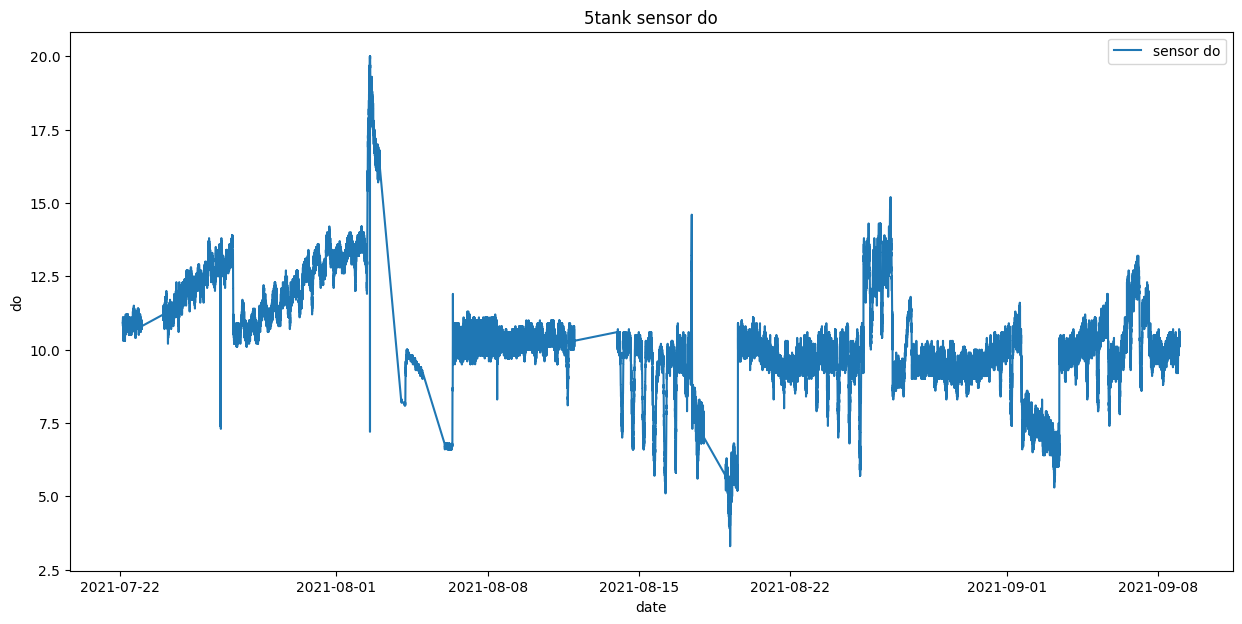

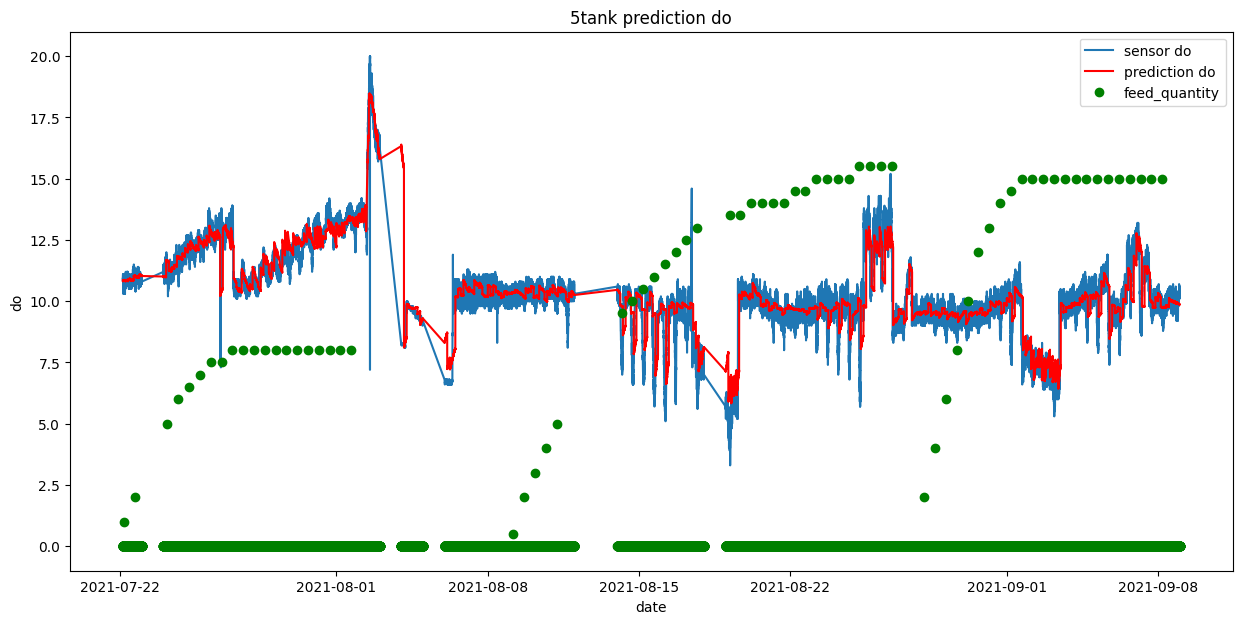

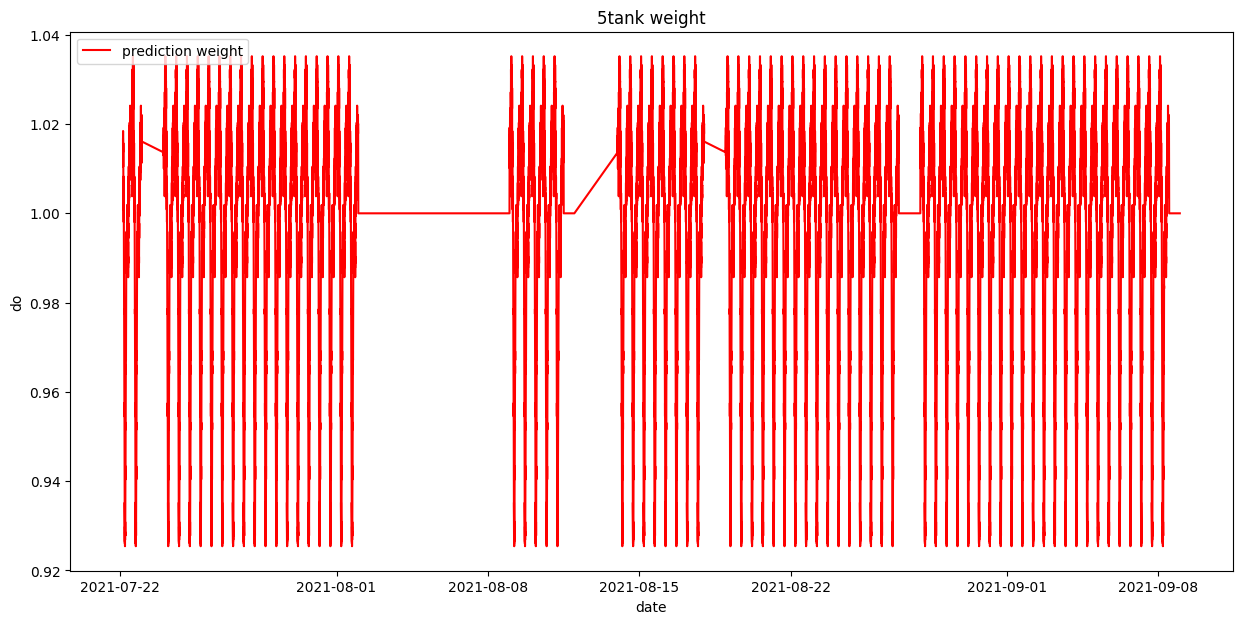

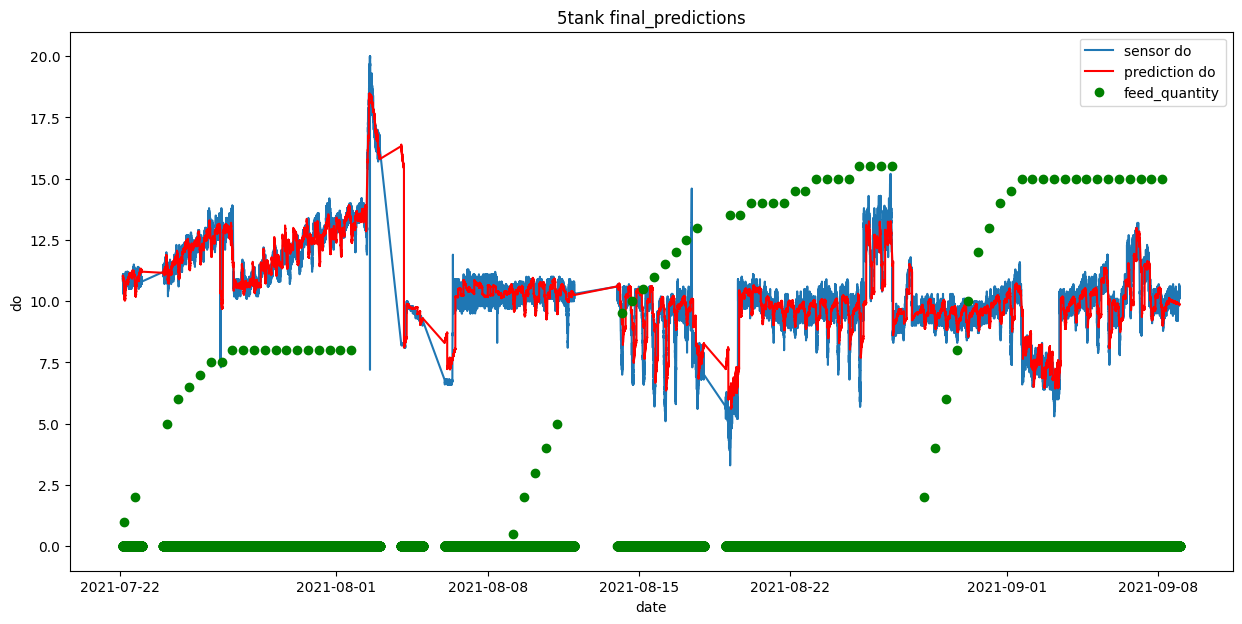

Euclidean Distance
 225.2043595171128  →  216.58130441609381
Cosine Similarity
 0.9963015455119552  →  0.9965713116602688
Correlation Coefficient
 0.1266850709956474  →  0.11672509714849855
Mean Squared Error
 0.8214610227650385  →  0.7597580405341225
Mean Absolute Error
 0.5251489649059937  →  0.5245798578814168
Correlation Coefficient
 0.8733149290043525  →  0.8832749028515


In [11]:
grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 12780 nVar: 1
nCar: 71 nVar: 9
nCar: 71 nVar: 9
1/1 [==============================] - 0s 99ms/step


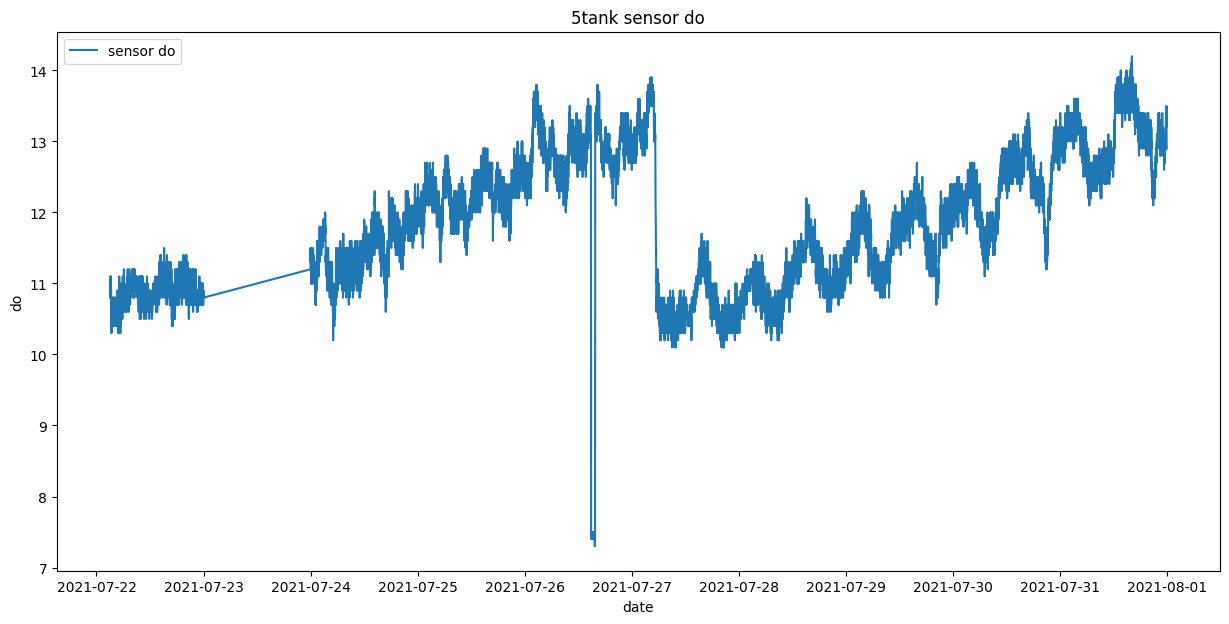

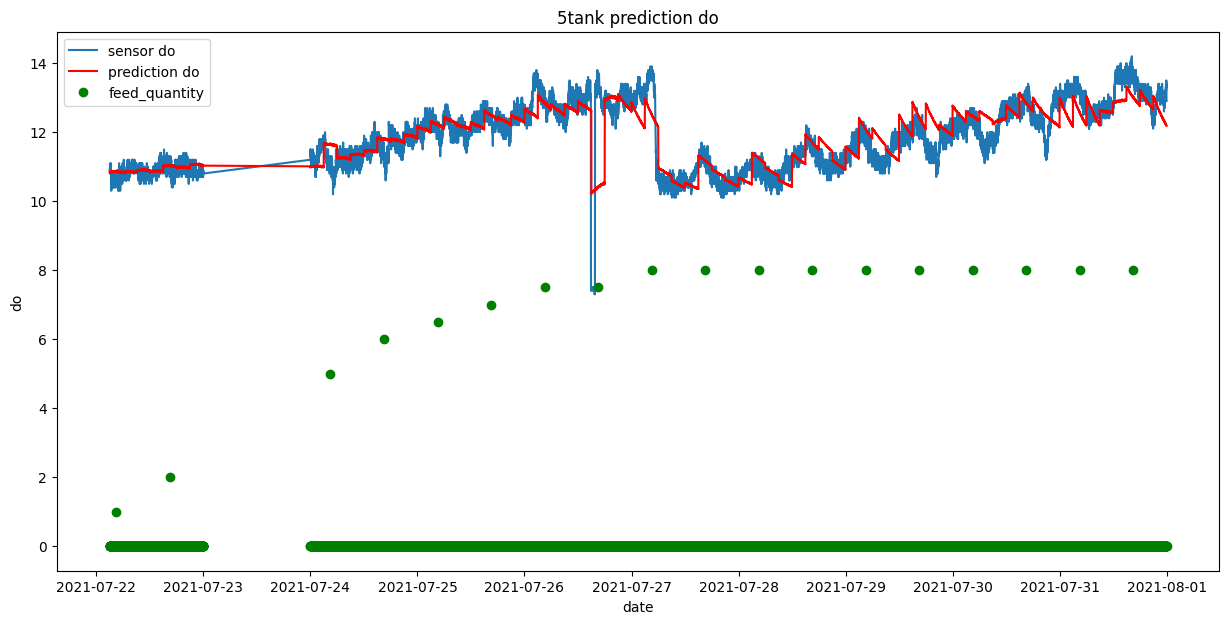

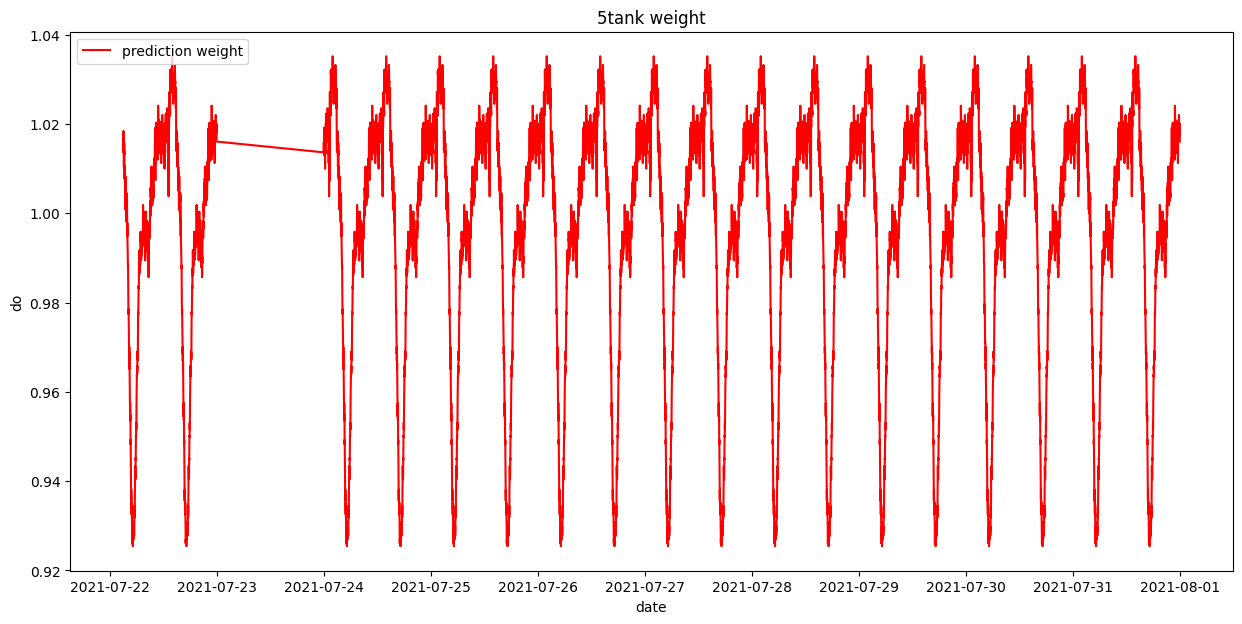

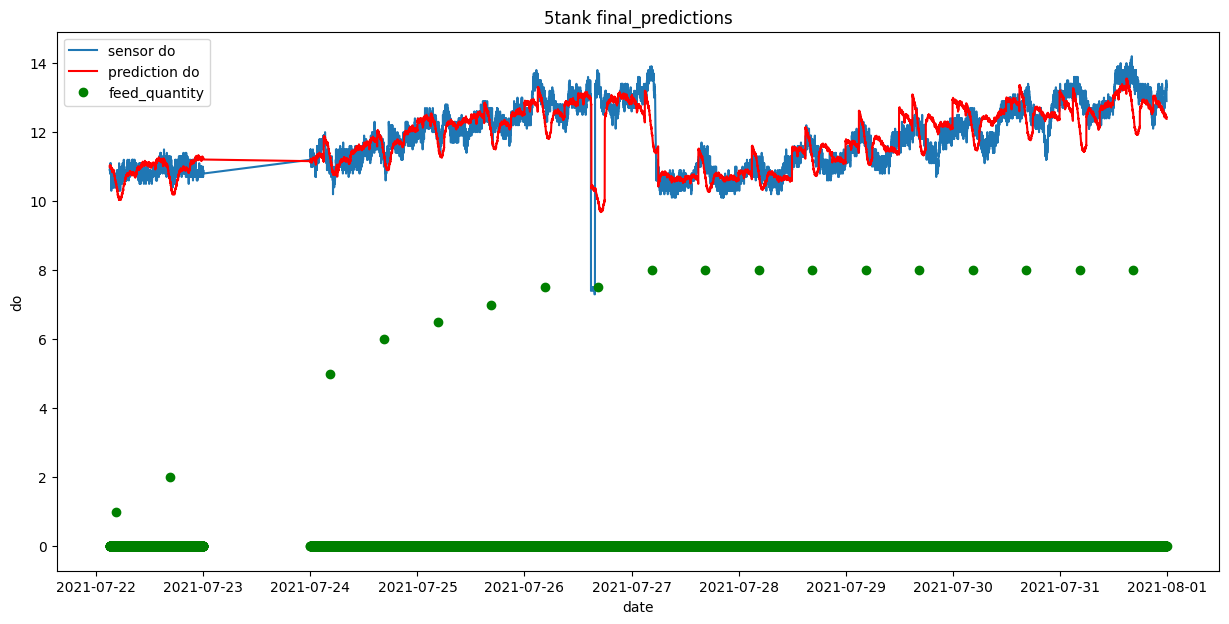

Euclidean Distance
 61.69315127746411  →  67.76549166979214
Cosine Similarity
 0.9989477344911756  →  0.9987307277259075
Correlation Coefficient
 0.18176536664616838  →  0.21739075417216835
Mean Squared Error
 0.2978125911223844  →  0.3593240892995826
Mean Absolute Error
 0.3626940227114538  →  0.3910362661231776
Correlation Coefficient
 0.8182346333538314  →  0.7826092458278316


In [12]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-31 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 7020 nVar: 1
nCar: 39 nVar: 9
nCar: 39 nVar: 9
1/1 [==============================] - 0s 94ms/step


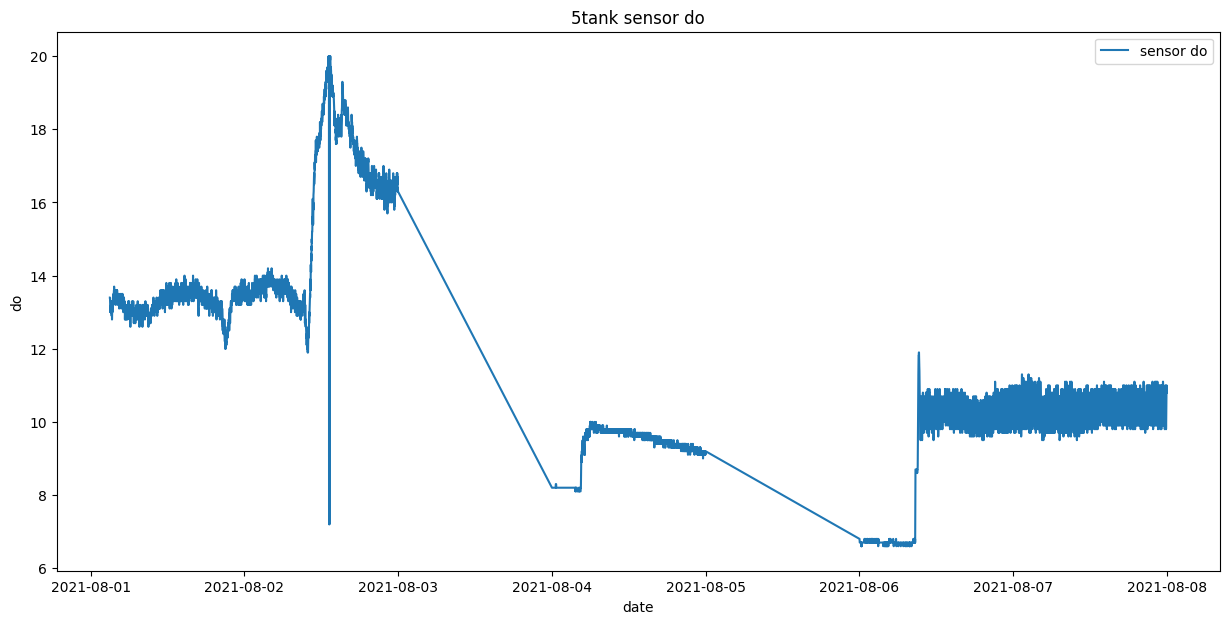

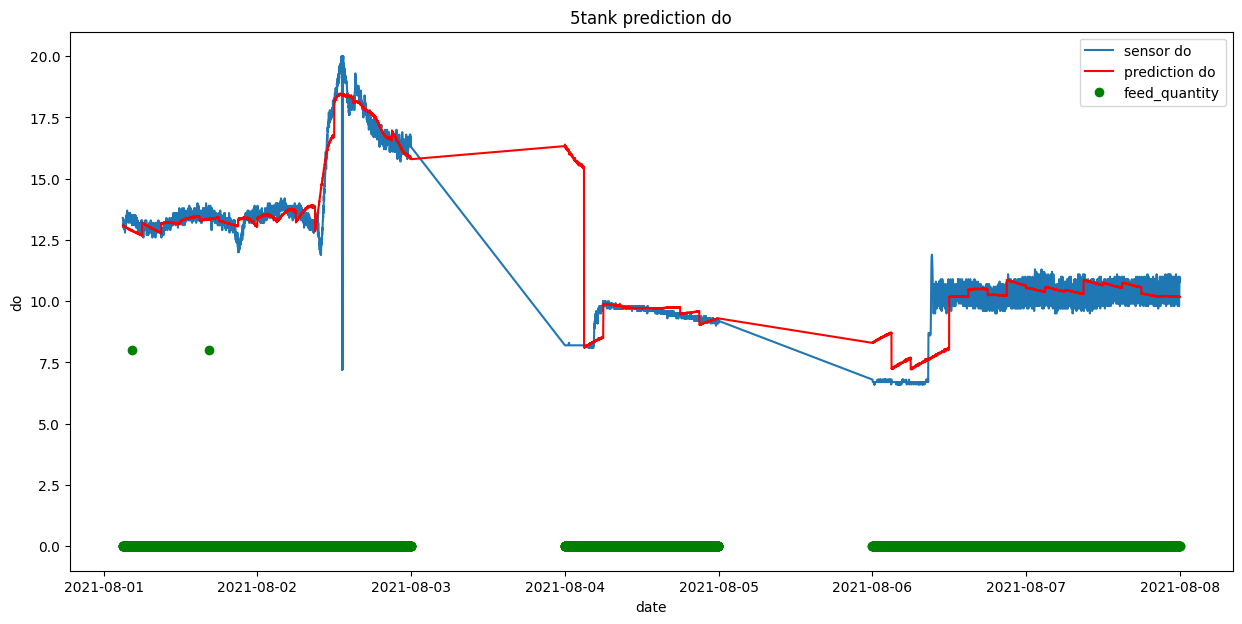

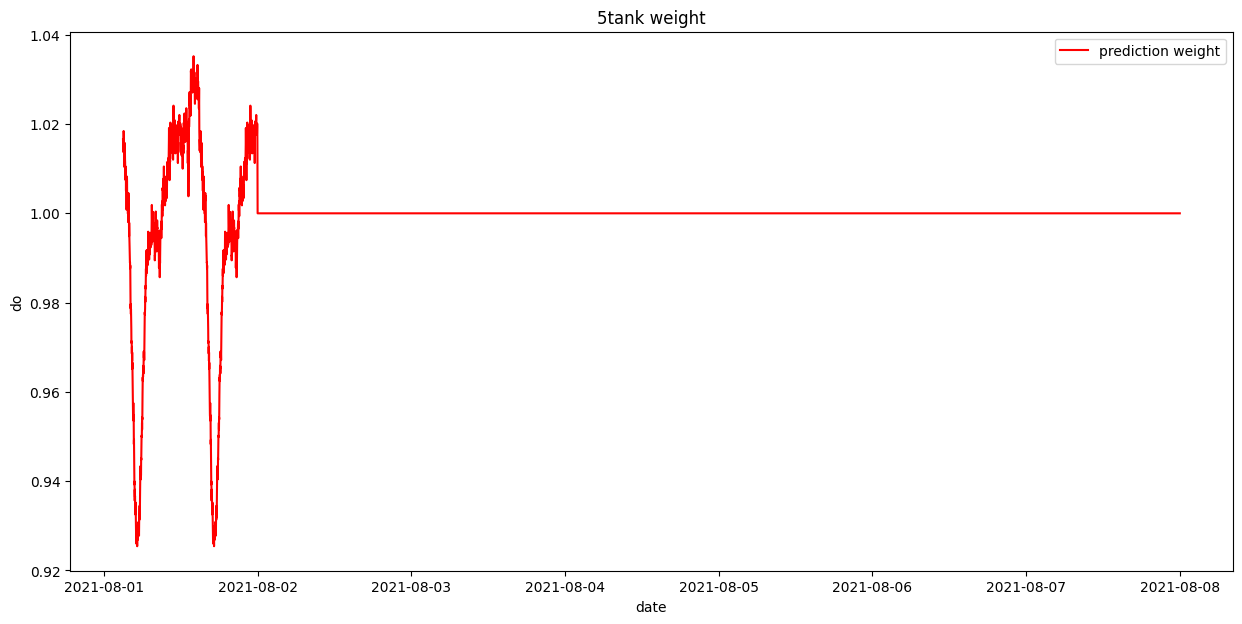

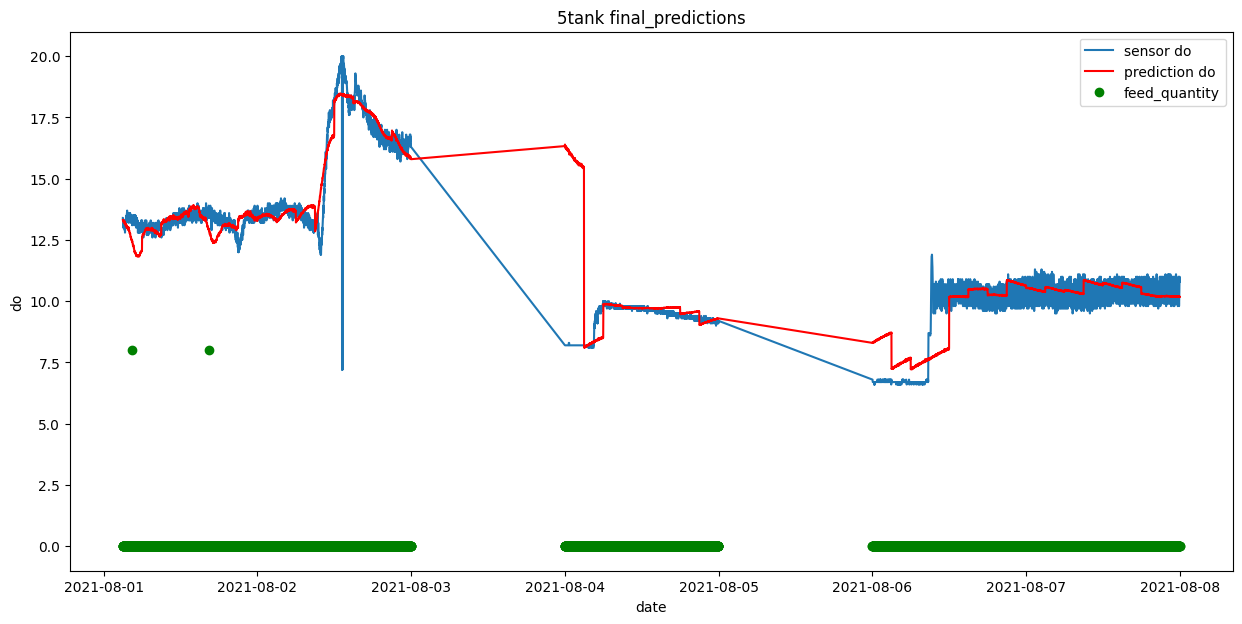

Euclidean Distance
 118.16104475977554  →  119.0558624835352
Cosine Similarity
 0.9931780408811406  →  0.9930470916656536
Correlation Coefficient
 0.11759328417576032  →  0.11982171008399933
Mean Squared Error
 1.9888935183364256  →  2.0191308250282725
Mean Absolute Error
 0.6311548595754509  →  0.6560057750949683
Correlation Coefficient
 0.8824067158242397  →  0.8801782899160001


In [13]:
y_date = japonica_validation_features_y.loc['2021-08-01 03:00':'2021-08-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
1
X_test1 = japonica_validation_features_X_a.loc['2021-08-01 00:00':'2021-08-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-01 03:00':'2021-08-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 8460 nVar: 1
nCar: 47 nVar: 9
nCar: 47 nVar: 9
1/1 [==============================] - 0s 96ms/step


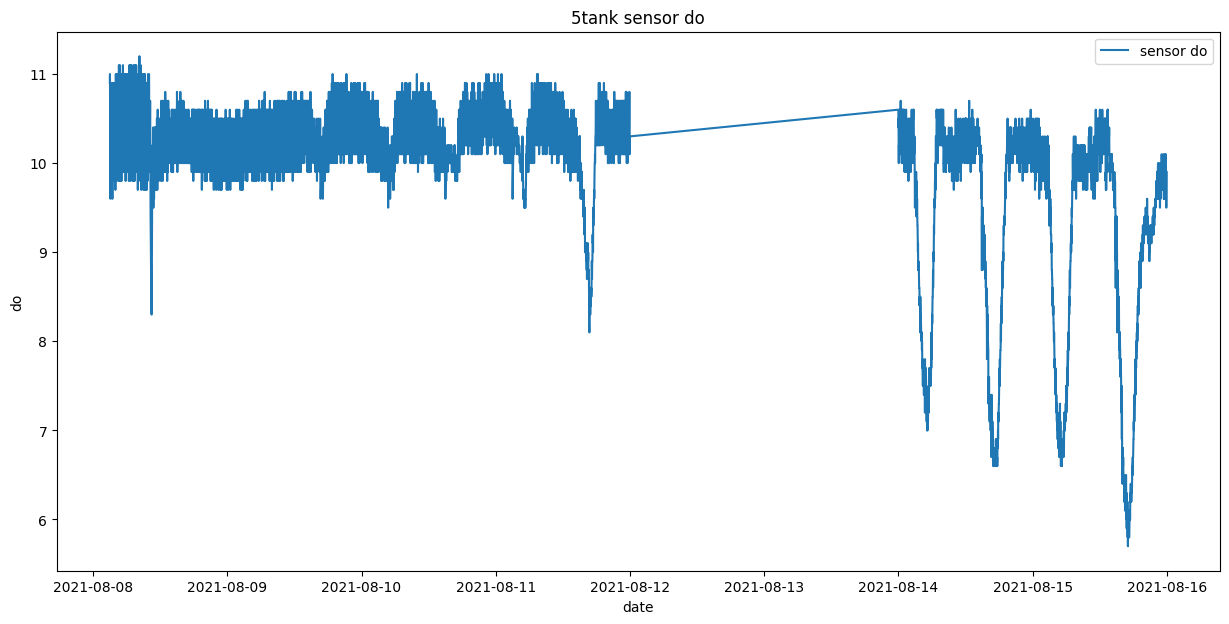

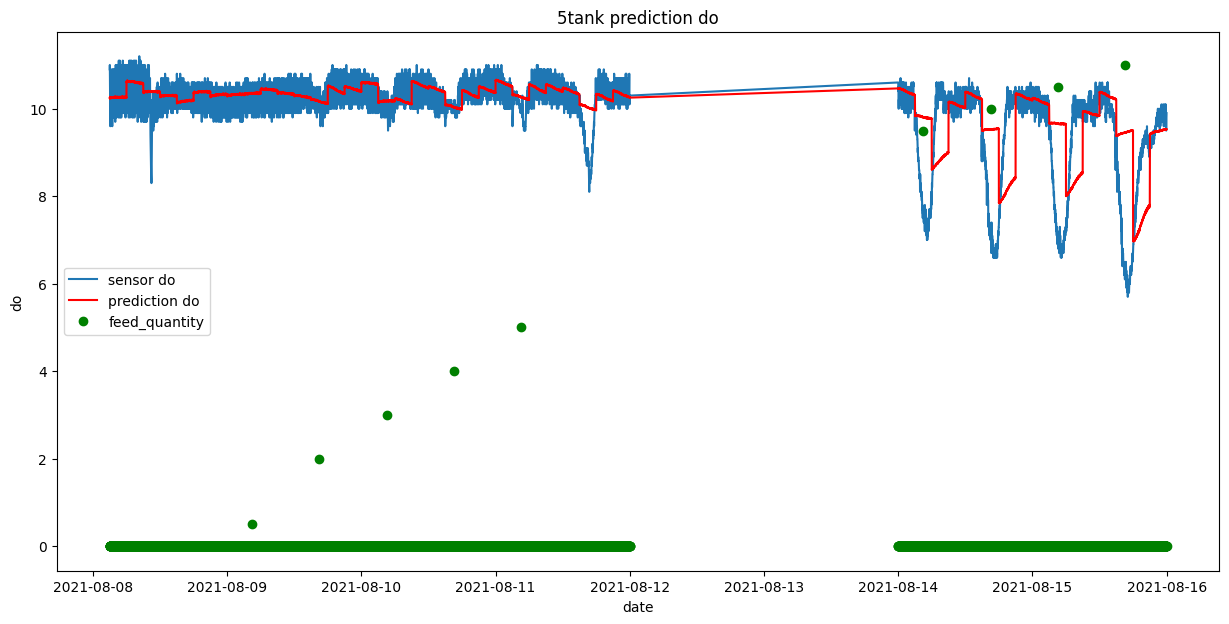

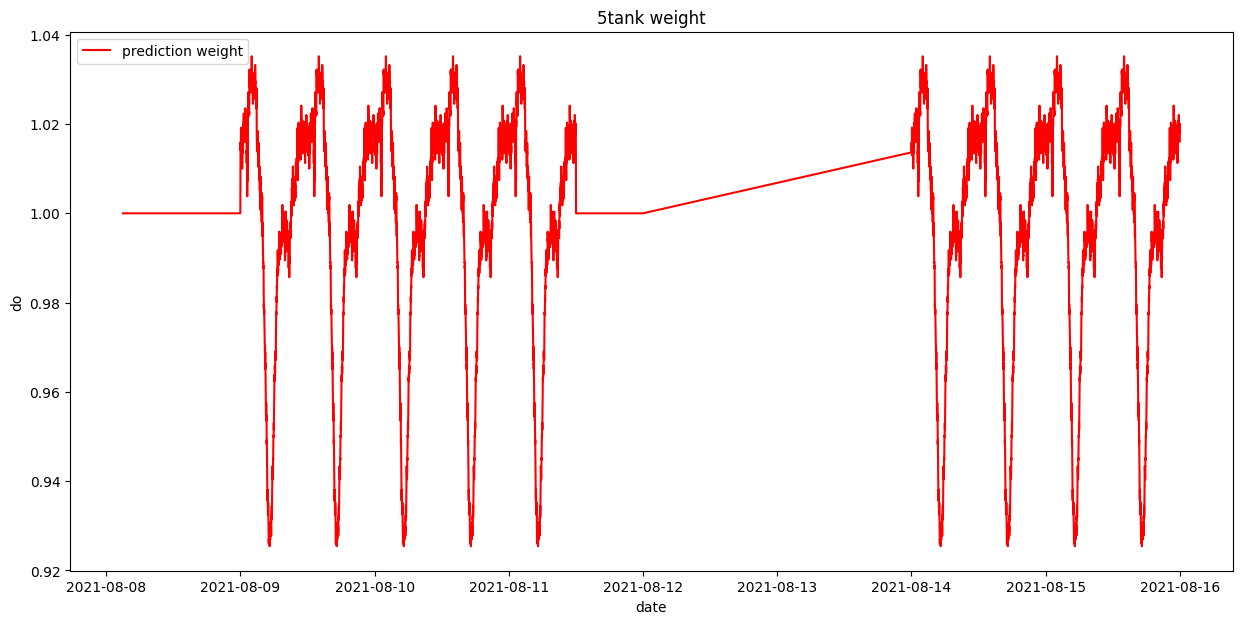

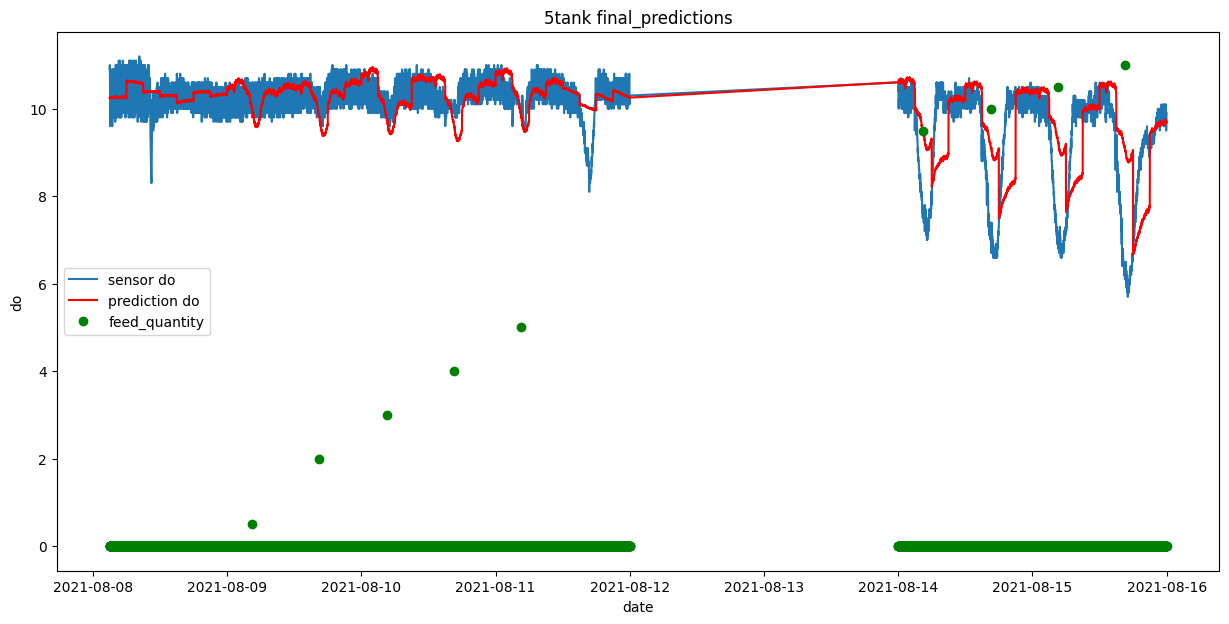

Euclidean Distance
 77.2631917756013  →  72.73668316740849
Cosine Similarity
 0.9965438271278301  →  0.9969377973031506
Correlation Coefficient
 0.5085985295156601  →  0.4191983480488294
Mean Squared Error
 0.7056265725003953  →  0.6253693945858116
Mean Absolute Error
 0.4982837383459646  →  0.5269528843396418
Correlation Coefficient
 0.4914014704843399  →  0.5808016519511707


In [14]:
y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-15 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
1
X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-15 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-15 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 9900 nVar: 1
nCar: 55 nVar: 9
nCar: 55 nVar: 9
1/1 [==============================] - 0s 96ms/step


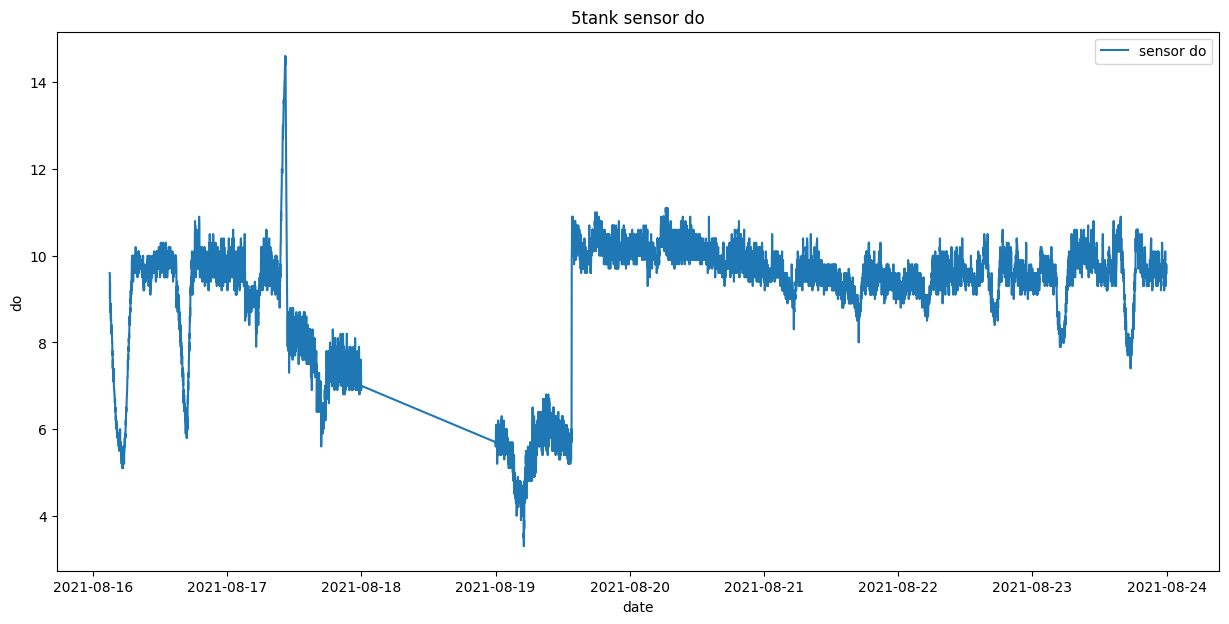

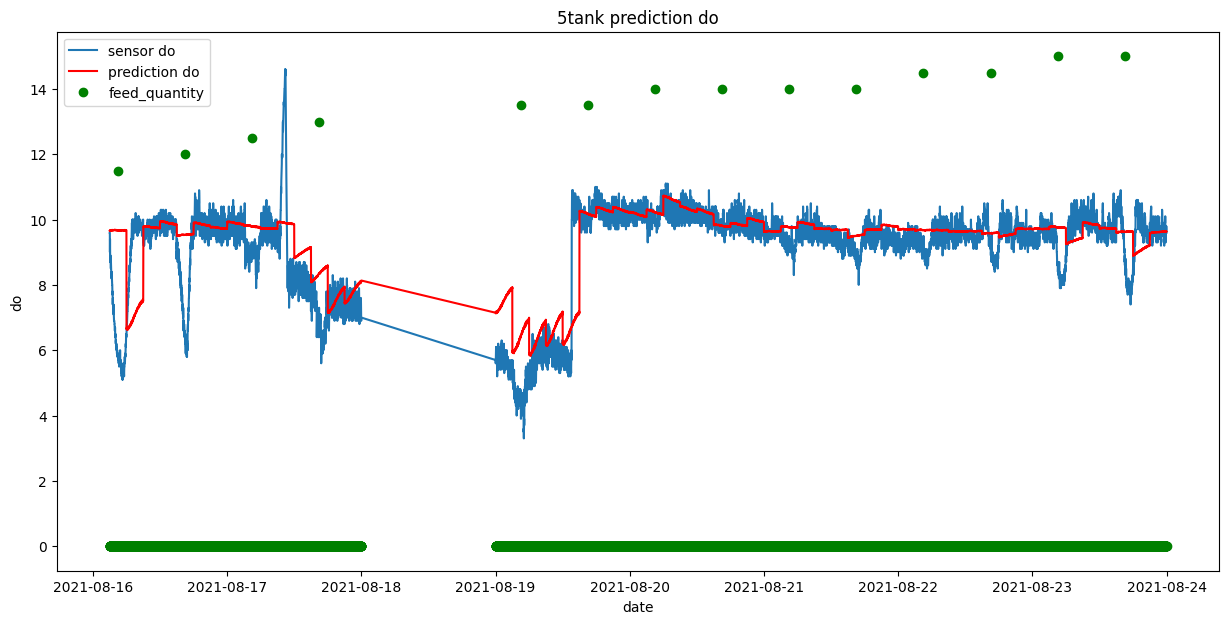

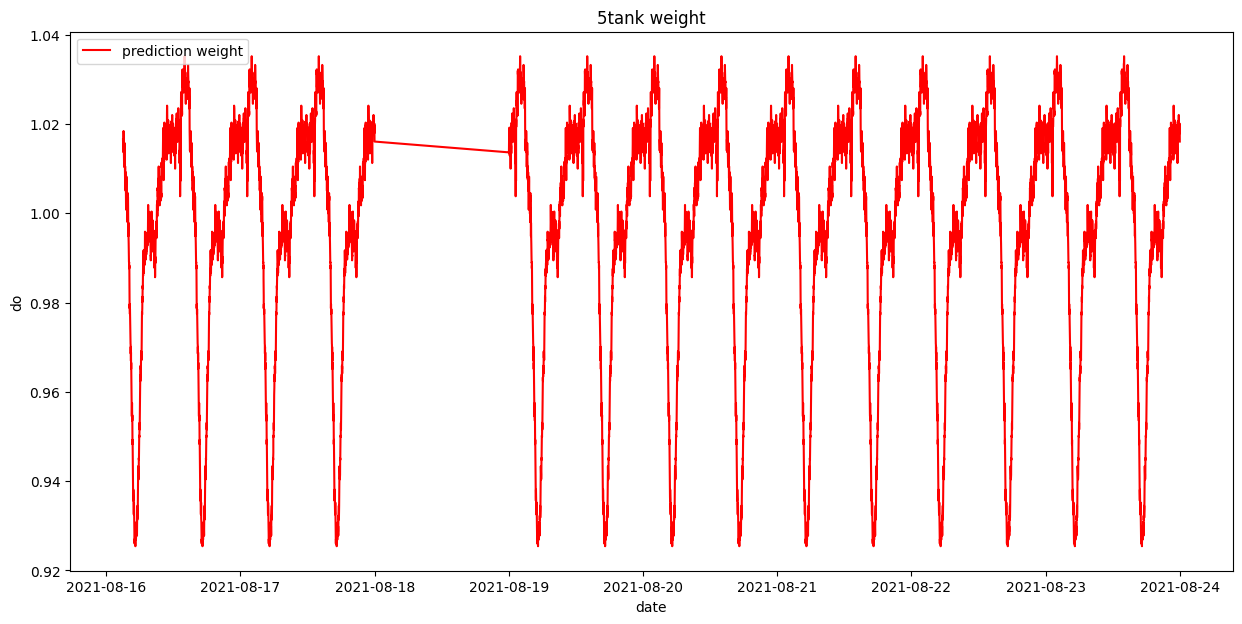

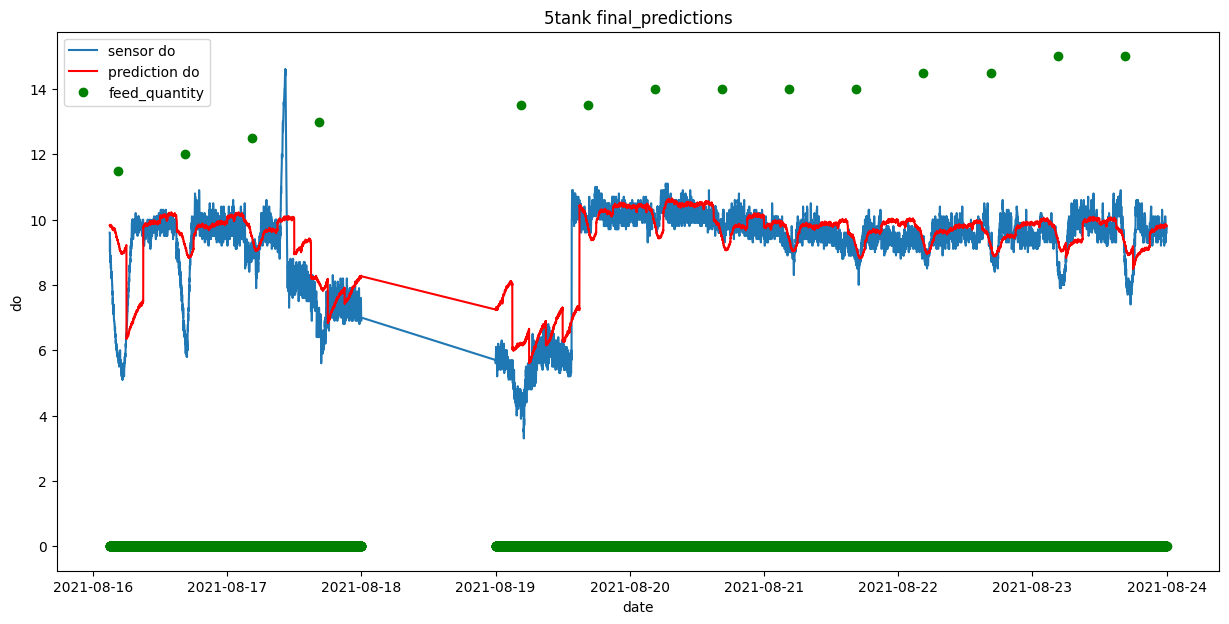

Euclidean Distance
 97.1044151325544  →  93.04810525602458
Cosine Similarity
 0.9947313203320497  →  0.9951338419440147
Correlation Coefficient
 0.24357145076268416  →  0.2223445650224768
Mean Squared Error
 0.9524512563874195  →  0.8745403931046694
Mean Absolute Error
 0.6000564696668375  →  0.610136904728357
Correlation Coefficient
 0.7564285492373151  →  0.7776554349775224


In [15]:
y_date = japonica_validation_features_y.loc['2021-08-16 03:00':'2021-08-23 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-16 00:00':'2021-08-23 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-16 03:00':'2021-08-23 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 11340 nVar: 1
nCar: 63 nVar: 9
nCar: 63 nVar: 9
1/1 [==============================] - 0s 98ms/step


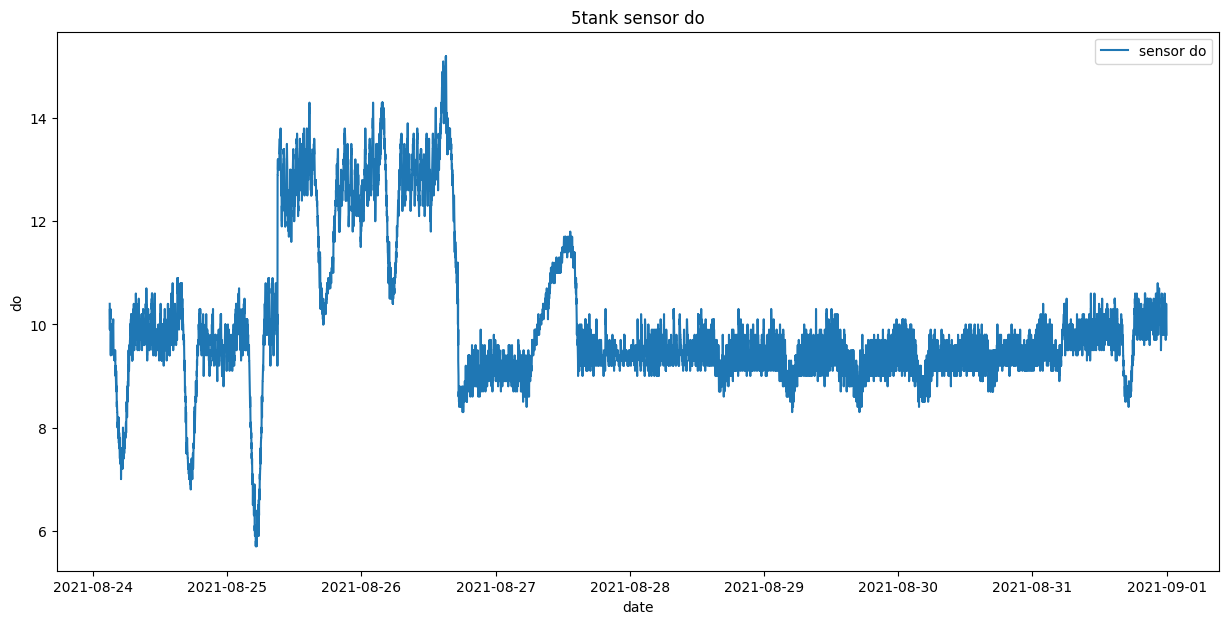

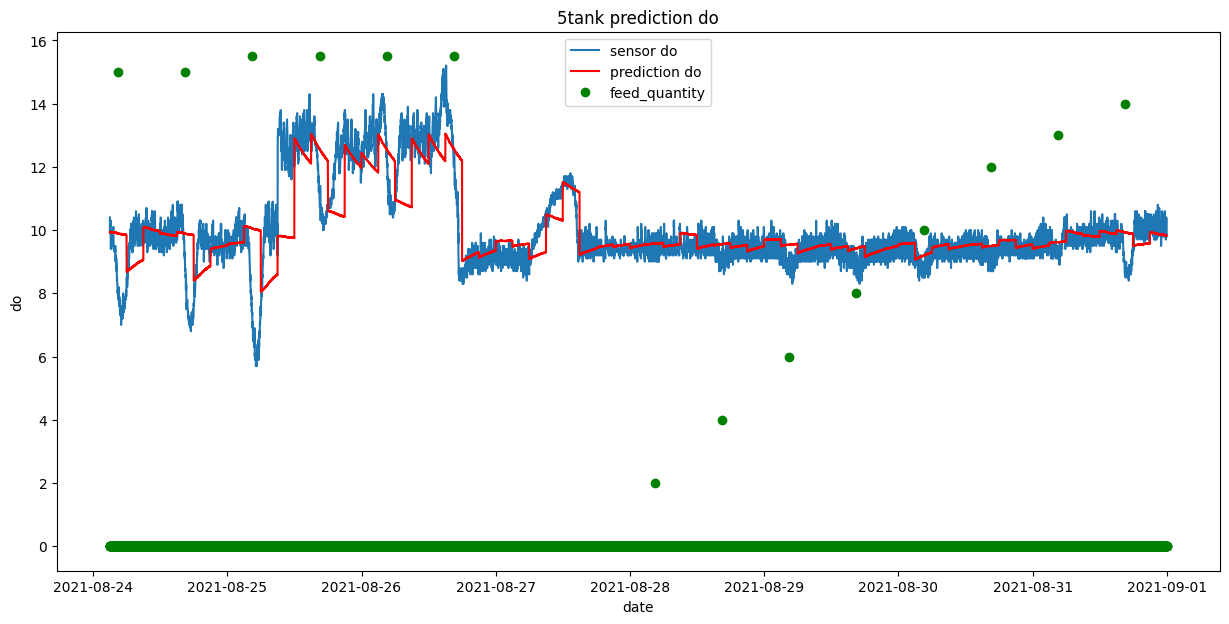

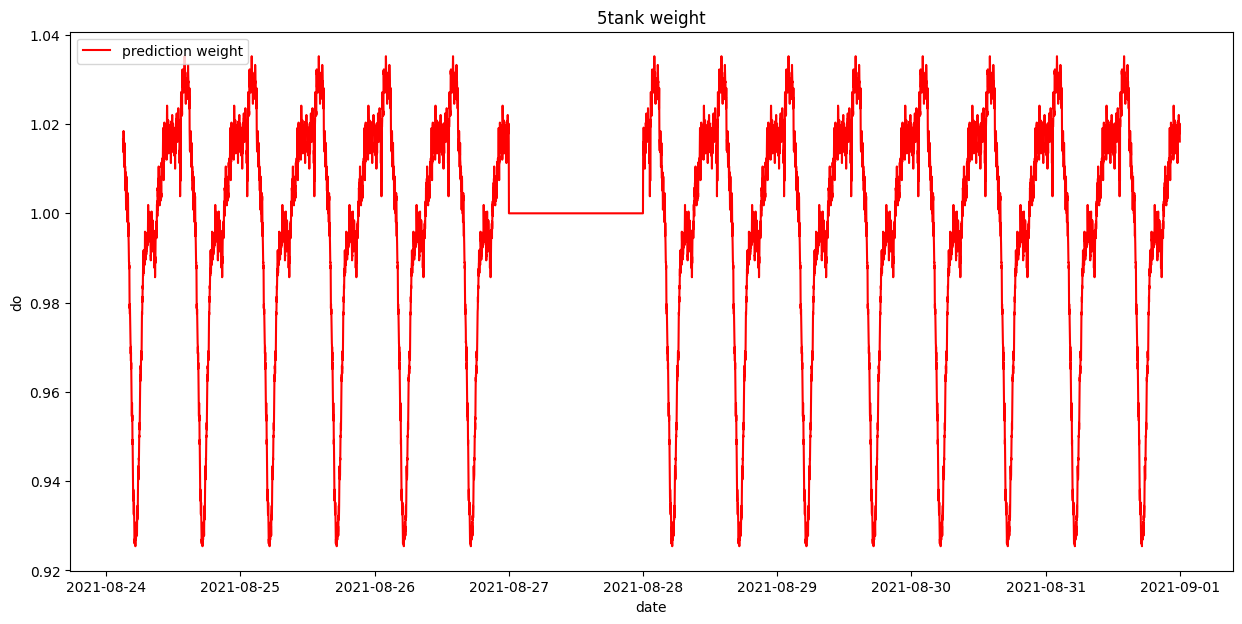

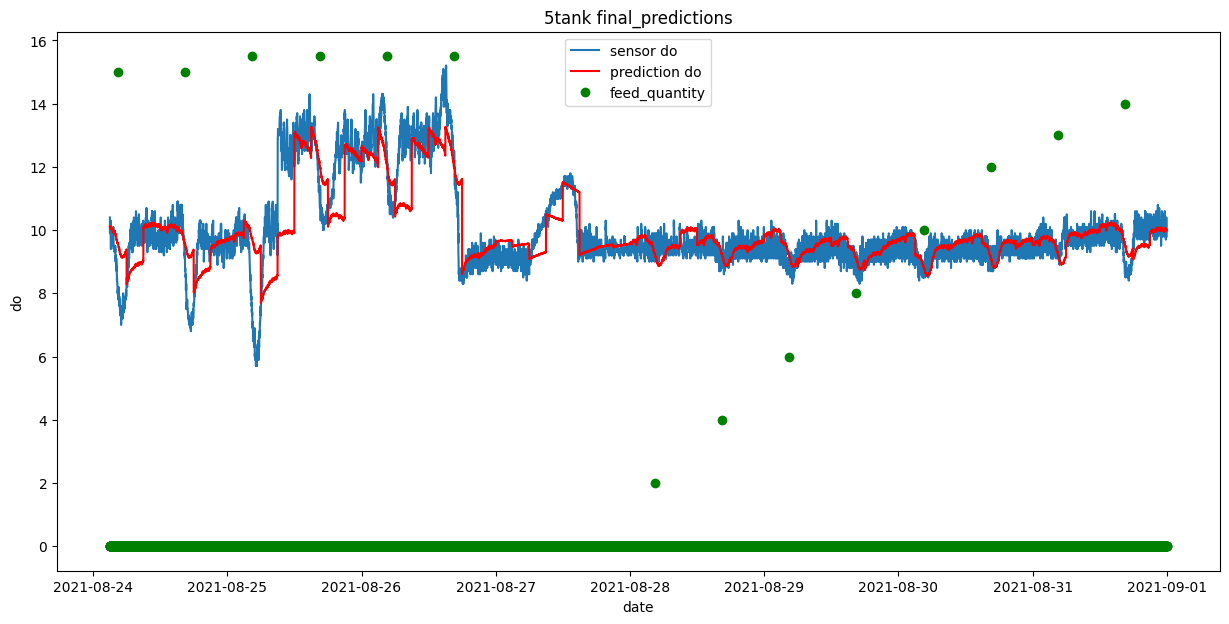

Euclidean Distance
 96.90109160579155  →  87.89670035950738
Cosine Similarity
 0.9959578903631235  →  0.9966898484243198
Correlation Coefficient
 0.2425470611679471  →  0.19293200618219186
Mean Squared Error
 0.8280265920982368  →  0.6812901176445344
Mean Absolute Error
 0.5688965399134936  →  0.5360547023388369
Correlation Coefficient
 0.7574529388320527  →  0.8070679938178082


In [16]:
y_date = japonica_validation_features_y.loc['2021-08-24 03:00':'2021-08-31 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-24 00:00':'2021-08-31 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-24 03:00':'2021-08-31 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 11340 nVar: 1
nCar: 63 nVar: 9
nCar: 63 nVar: 9
1/1 [==============================] - 0s 101ms/step


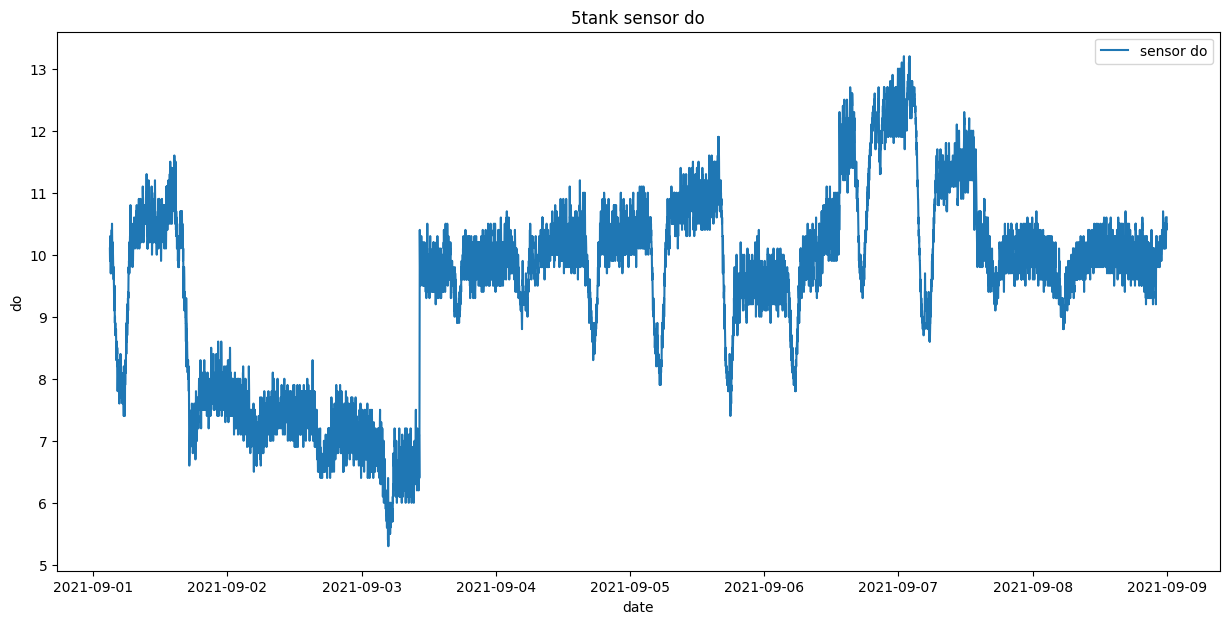

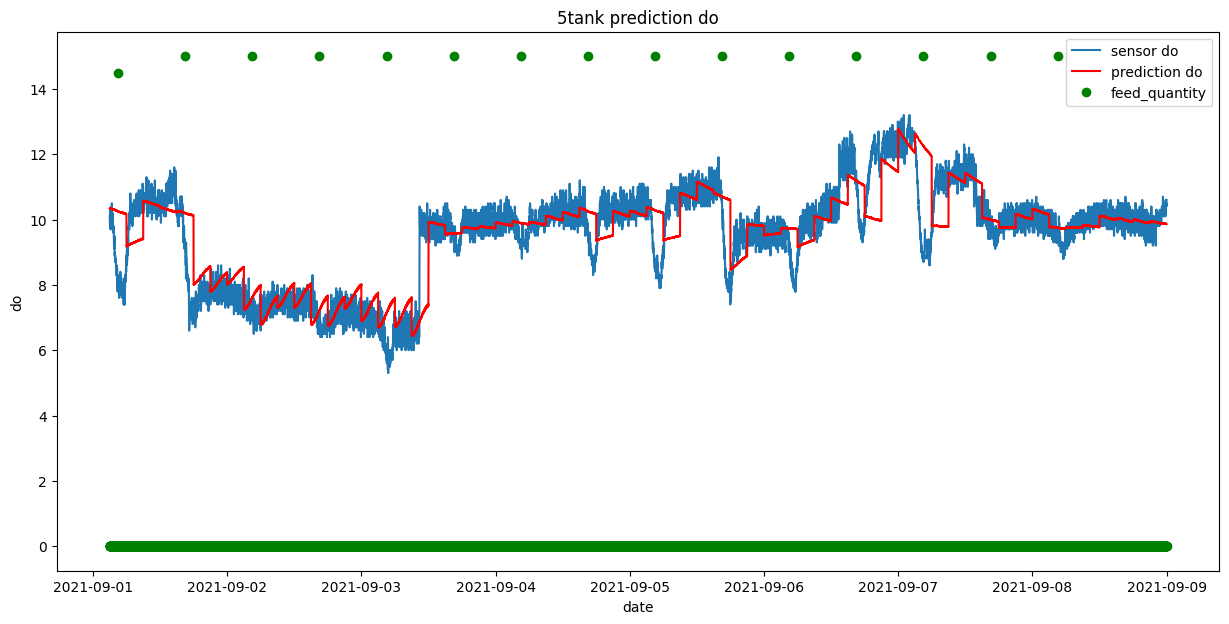

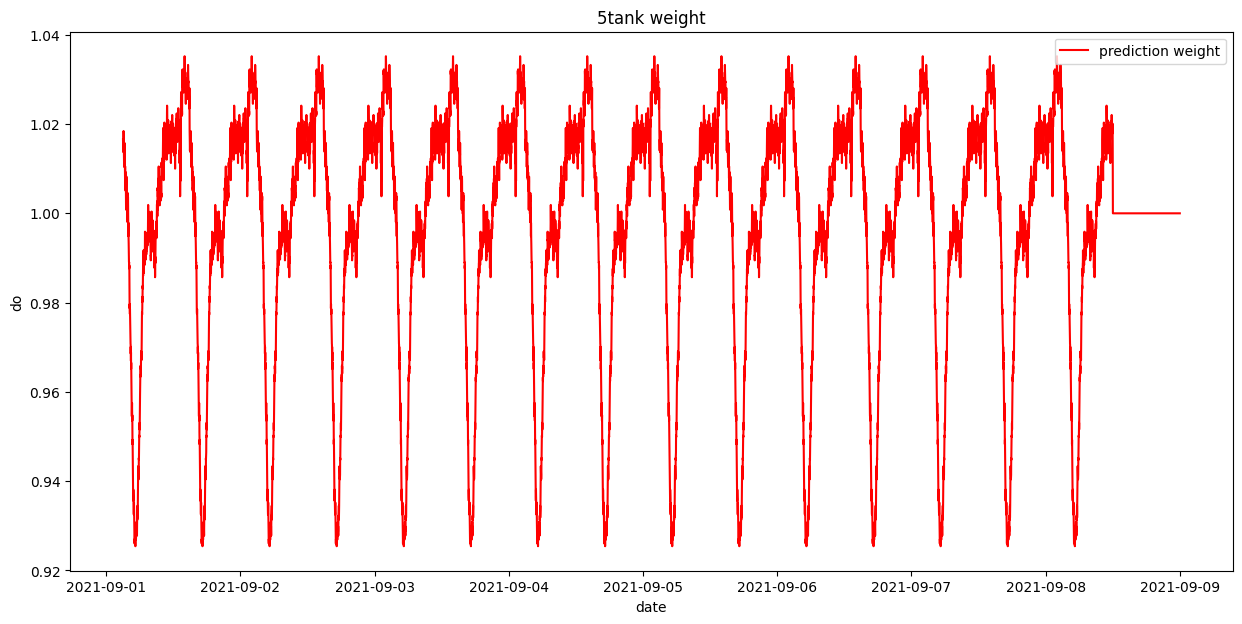

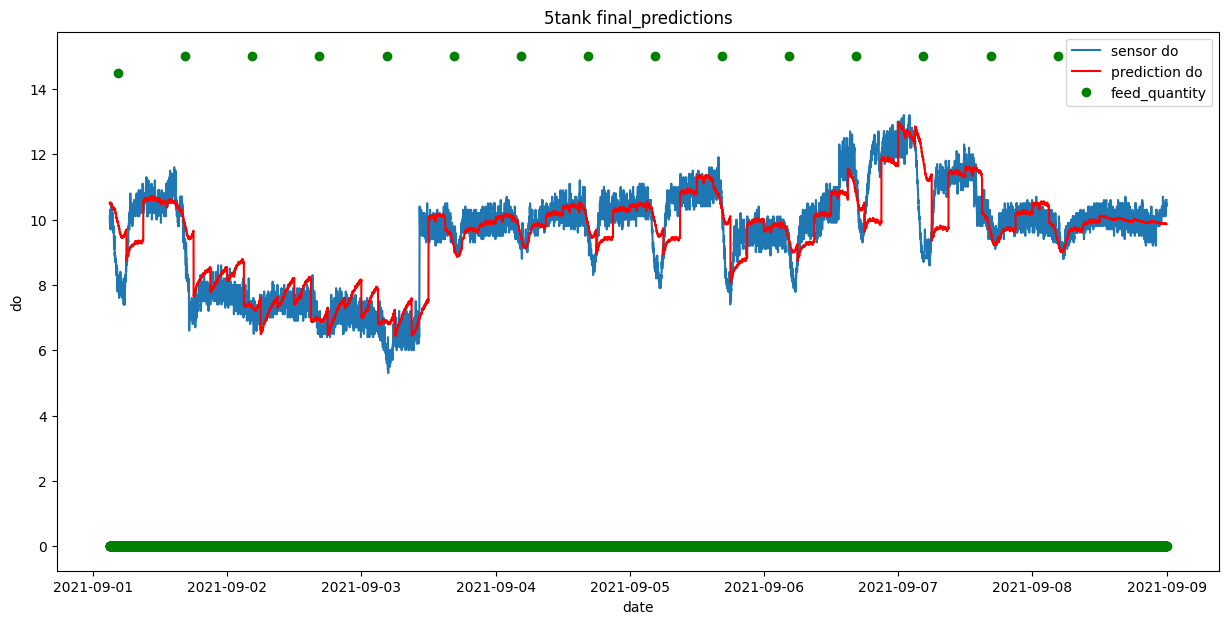

Euclidean Distance
 89.58285085106247  →  79.71141154537817
Cosine Similarity
 0.9962089231963908  →  0.9969927667382297
Correlation Coefficient
 0.17090261491623626  →  0.13298903705287157
Mean Squared Error
 0.7076796443213147  →  0.5603094471390339
Mean Absolute Error
 0.5702137813450378  →  0.5242301123929831
Correlation Coefficient
 0.8290973850837638  →  0.8670109629471282


In [17]:
y_date = japonica_validation_features_y.loc['2021-09-01 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-01 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-01 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 119ms/step


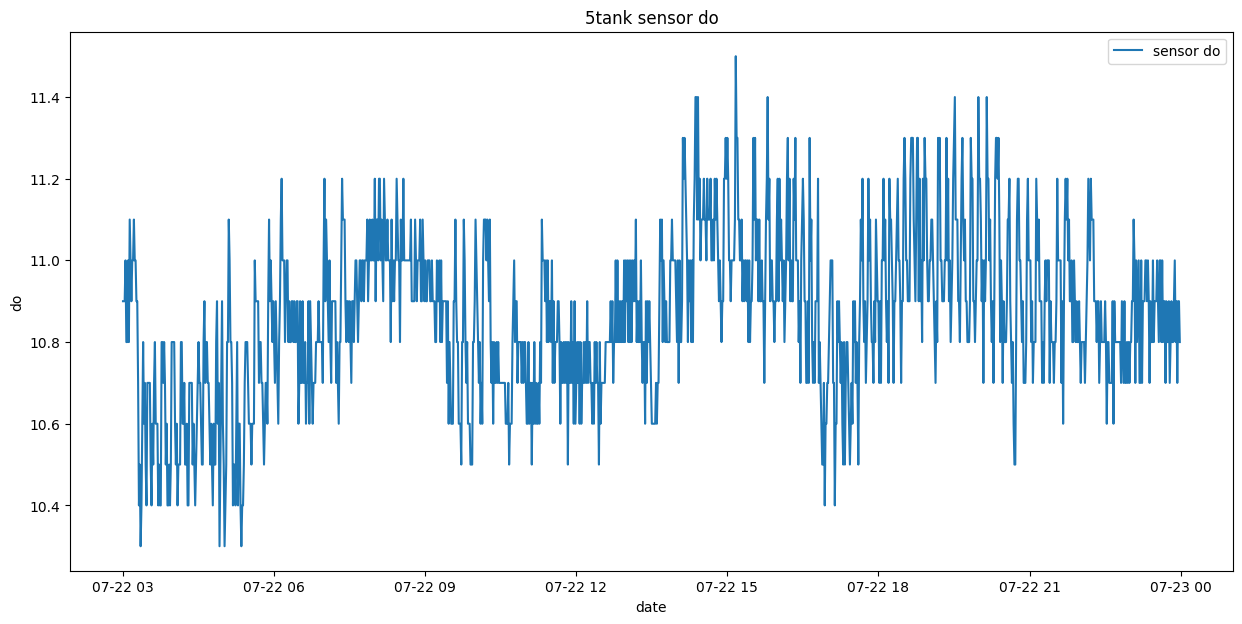

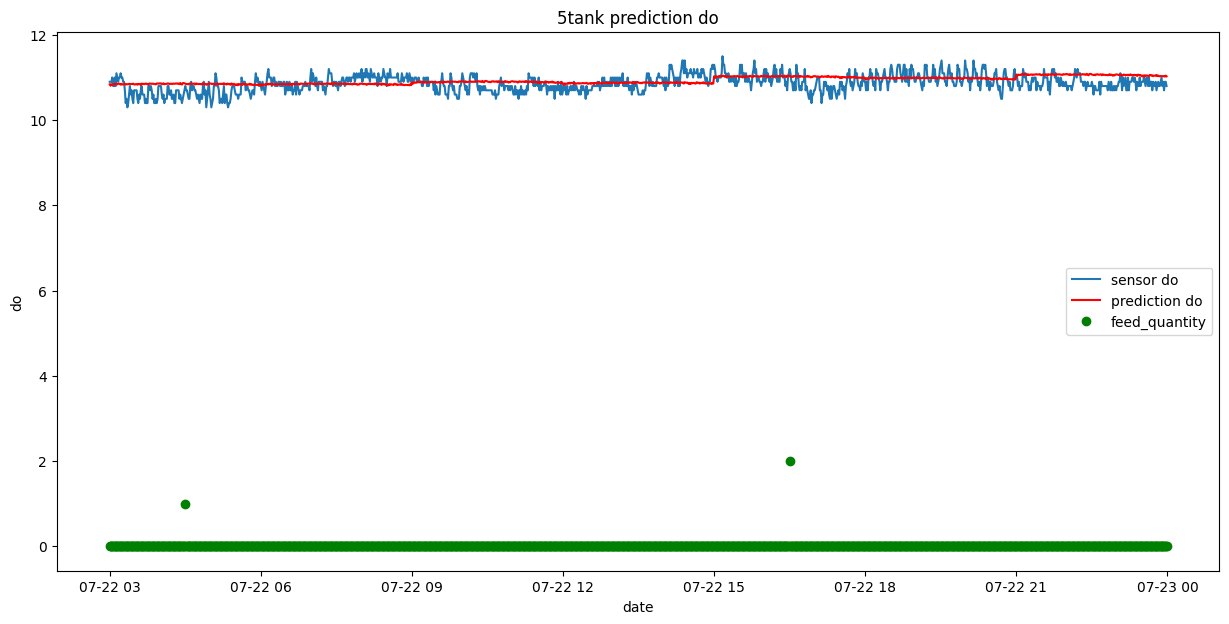

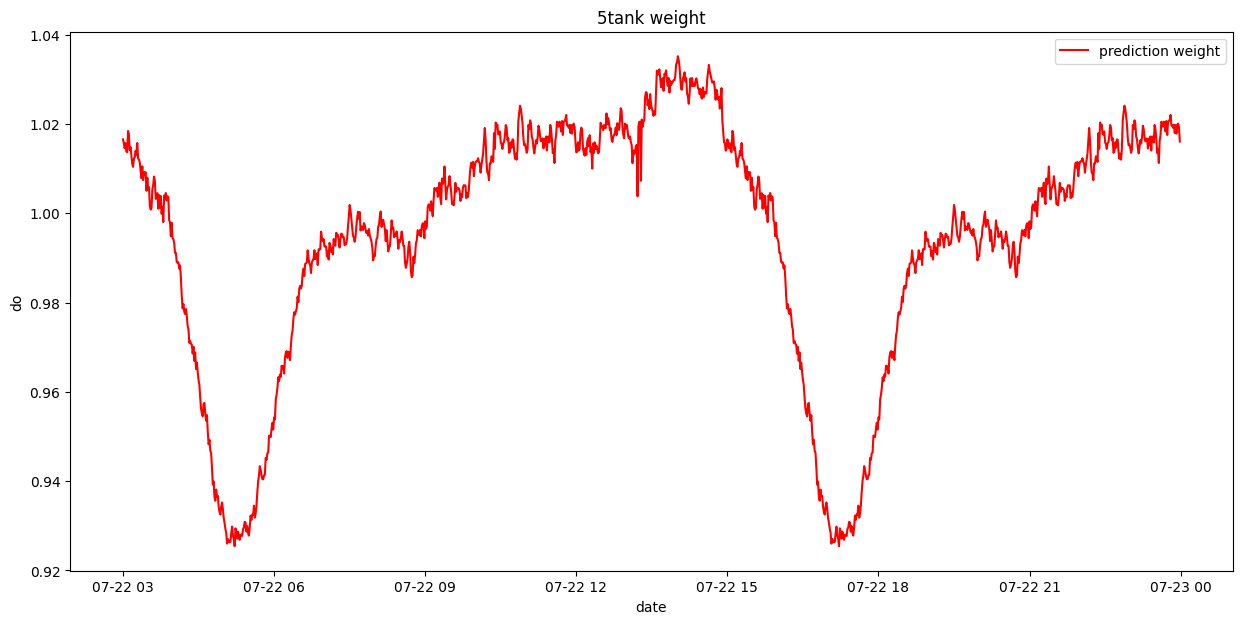

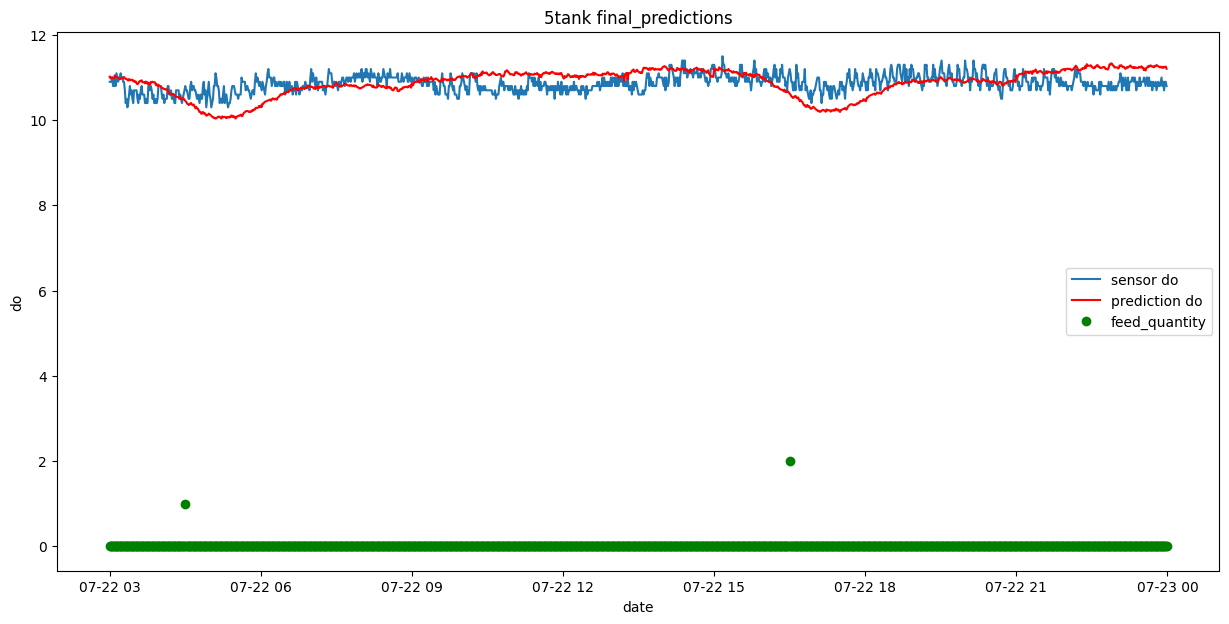

Euclidean Distance
 7.401693134390781  →  11.616949754066765
Cosine Similarity
 0.999835848035707  →  0.9995475844375666
Correlation Coefficient
 0.7738892323368756  →  0.7473264240562341
Mean Squared Error
 0.04348020734578384  →  0.107105969514692
Mean Absolute Error
 0.1709754212697346  →  0.2737020839651636
Correlation Coefficient
 0.22611076766312438  →  0.25267357594376605
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9


C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\4162643255.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\4162643255.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 92ms/step


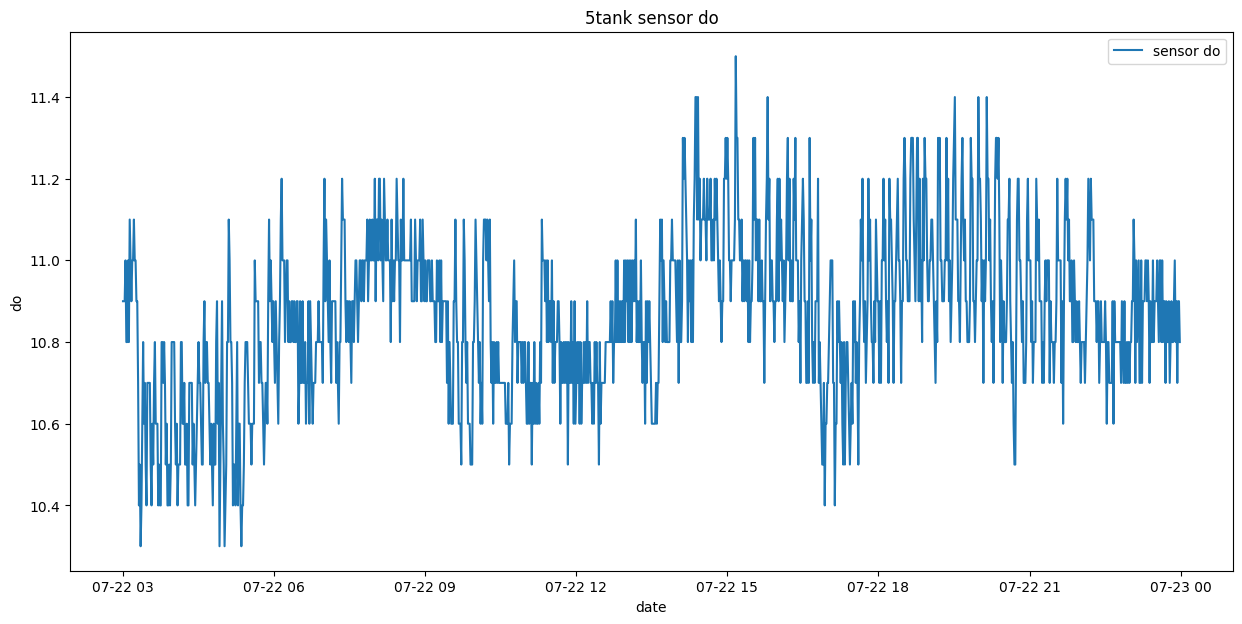

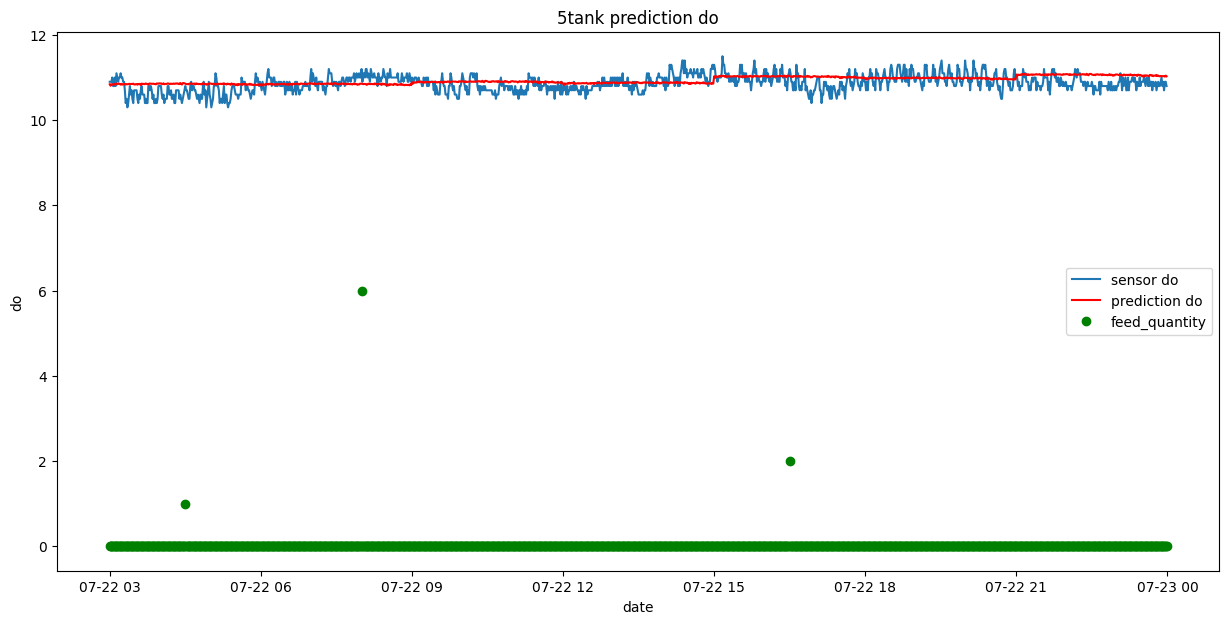

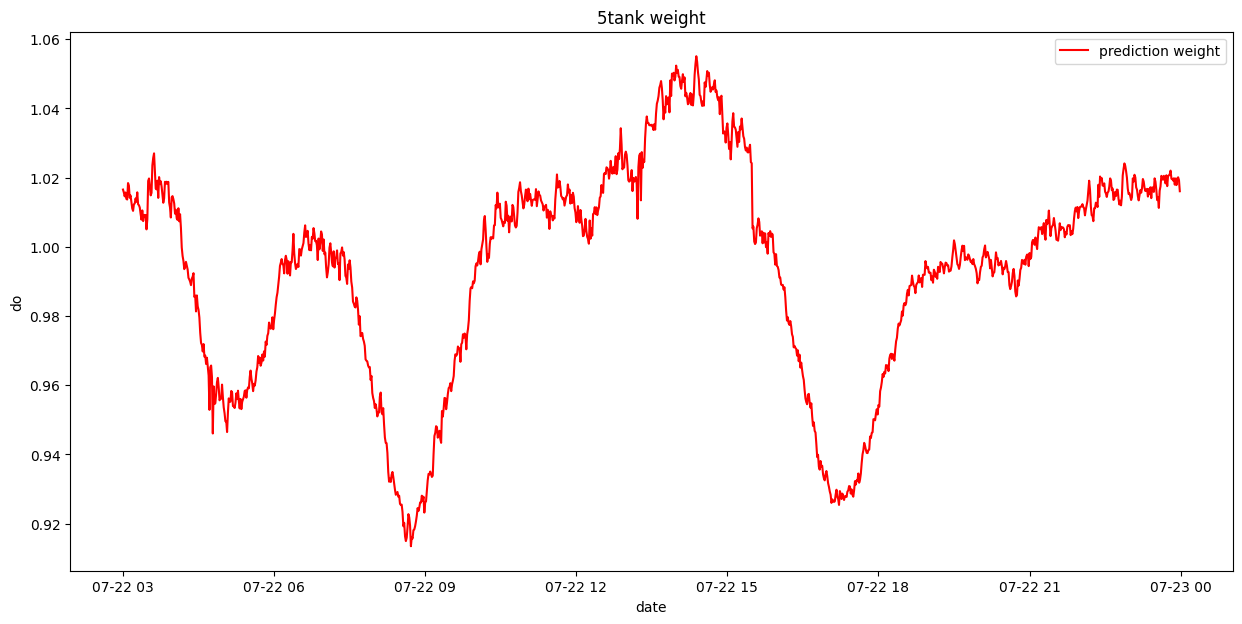

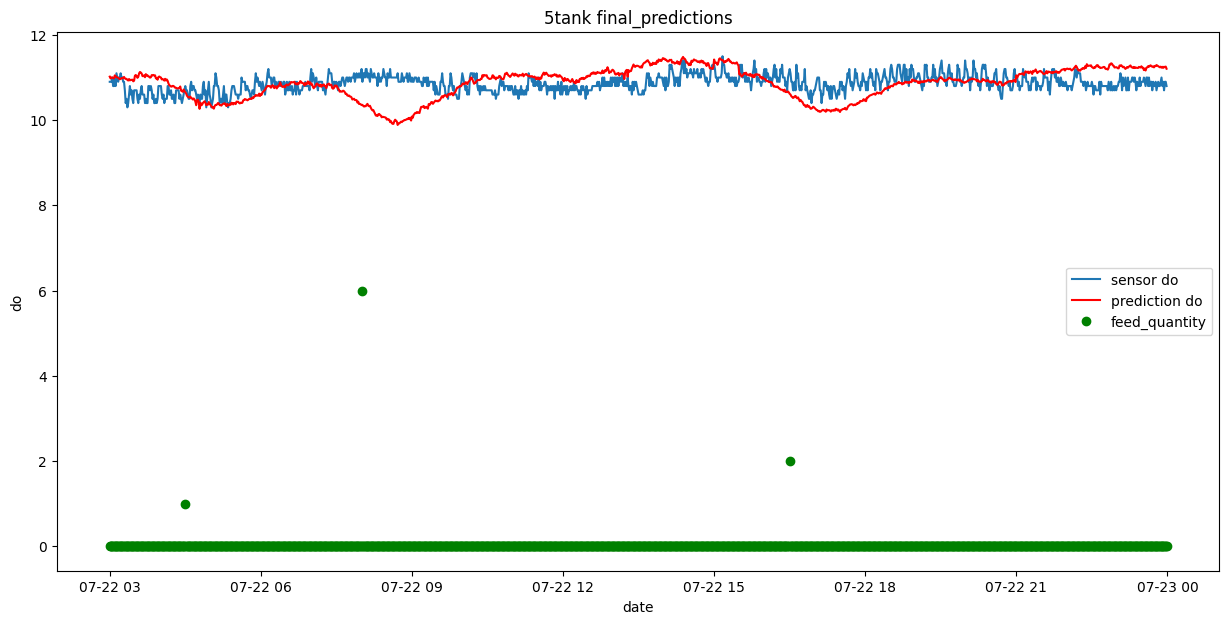

Euclidean Distance
 7.407180293554886  →  13.757122039016588
Cosine Similarity
 0.9998357478951693  →  0.9993639789147225
Correlation Coefficient
 0.7749028434547822  →  0.8821205072737767
Mean Squared Error
 0.043544698334307824  →  0.15020508475904434
Mean Absolute Error
 0.17110308253575876  →  0.3153748536783489
Correlation Coefficient
 0.22509715654521764  →  0.11787949272622328


In [18]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 1s 1s/step


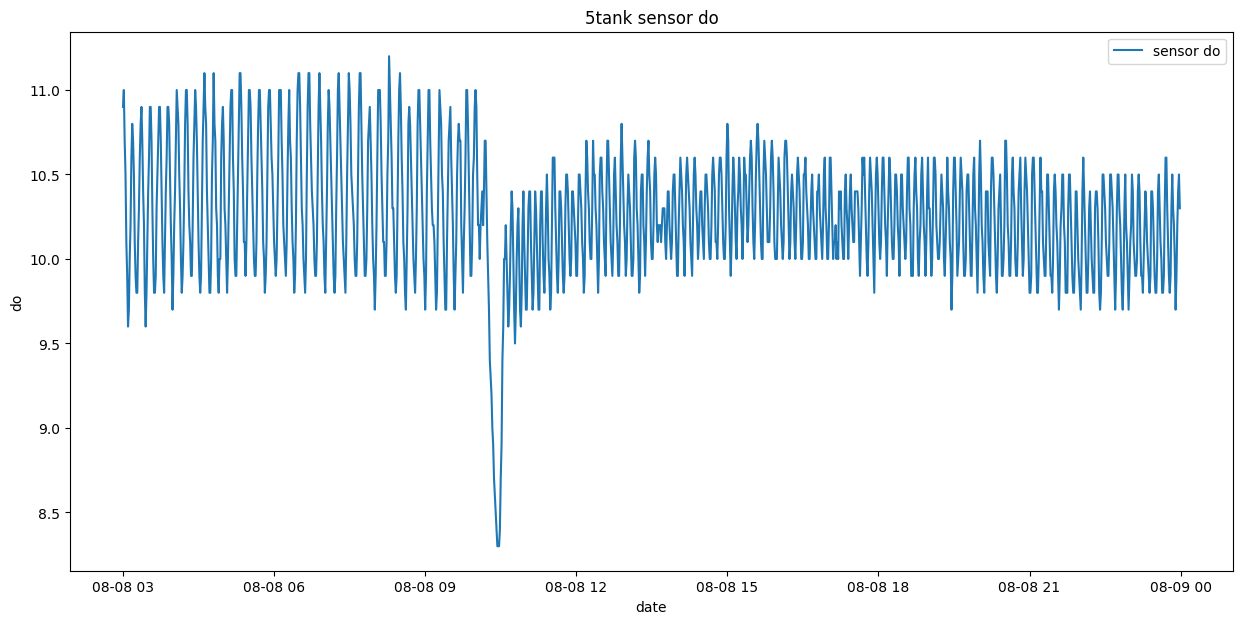

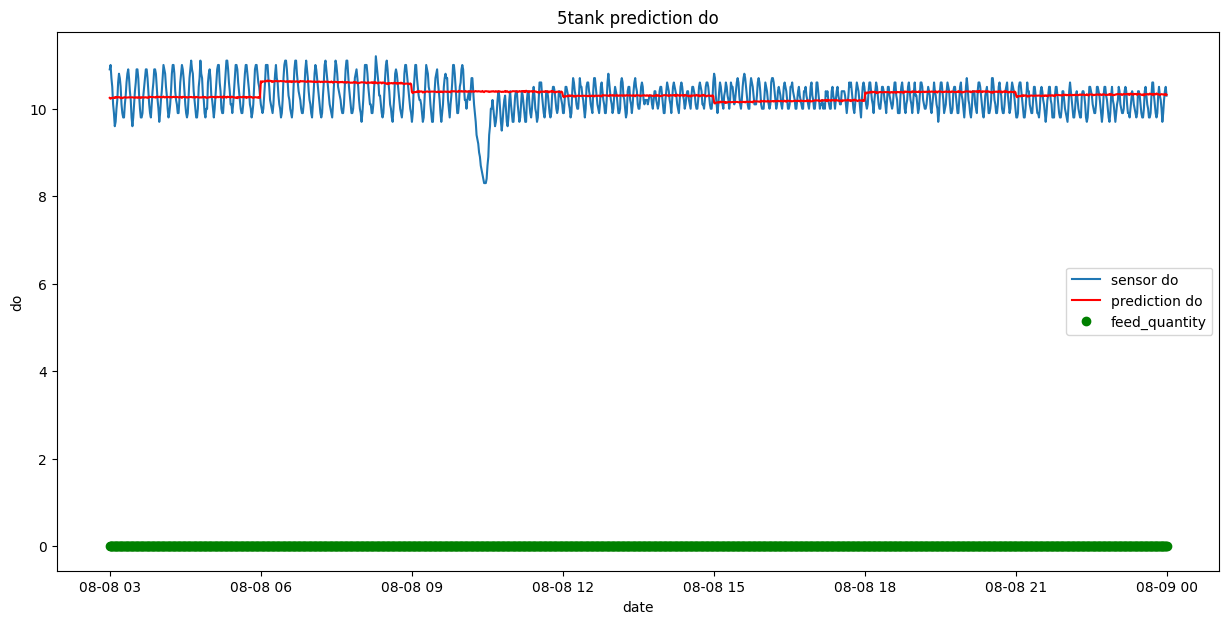

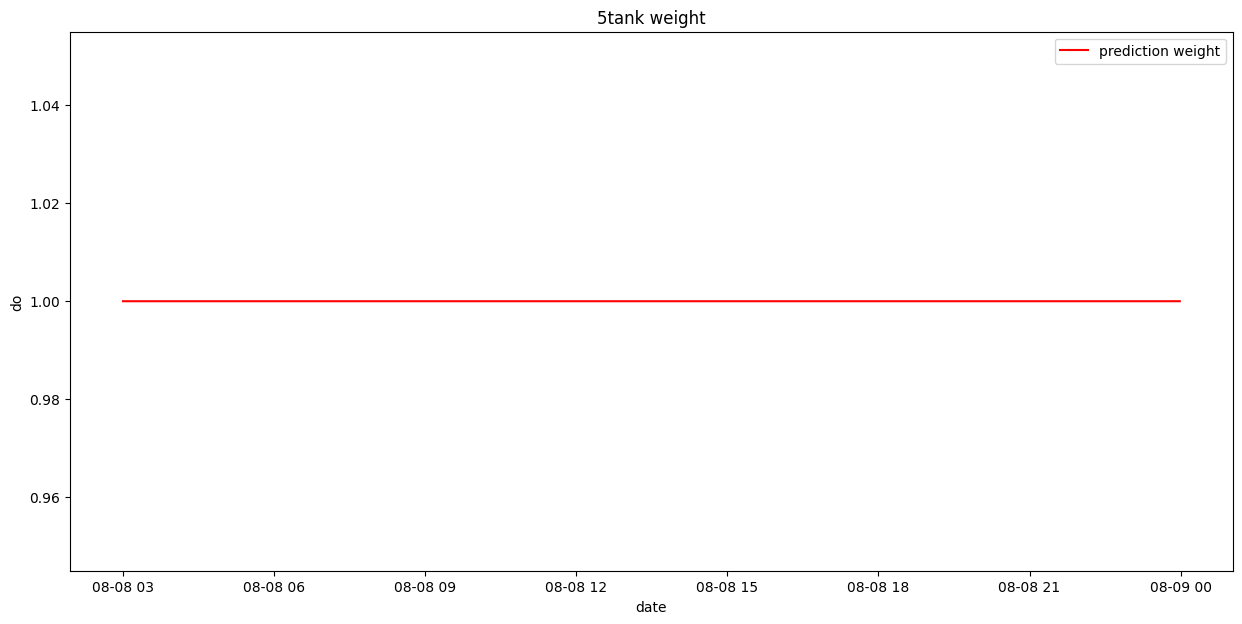

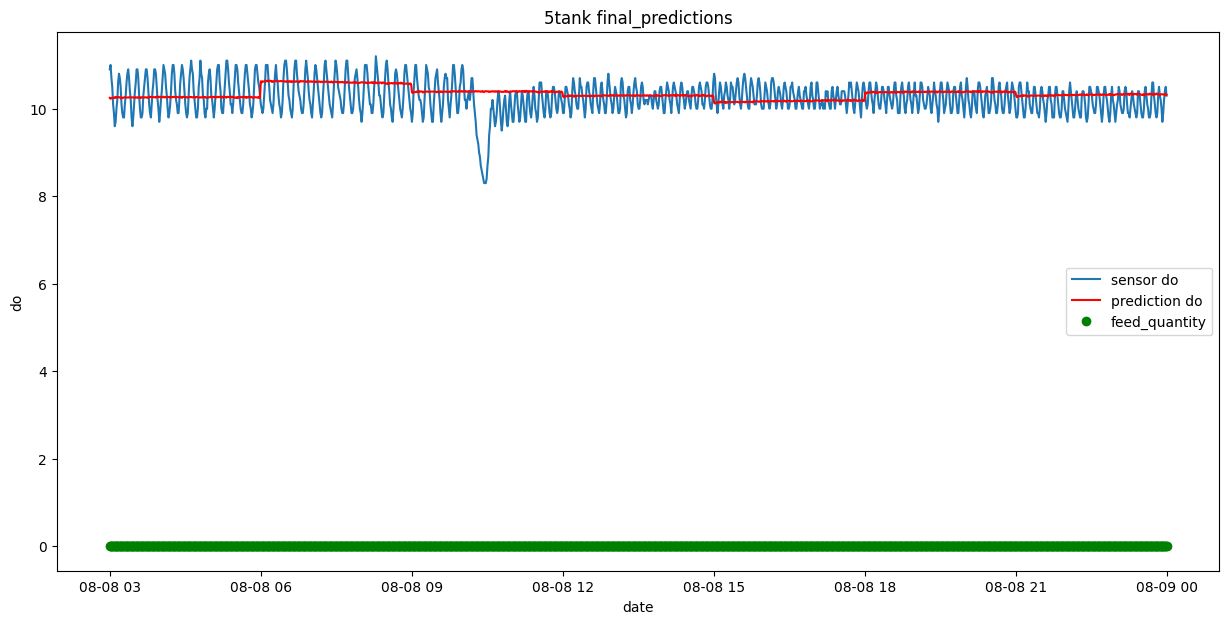

Euclidean Distance
 14.143092211997843  →  14.143092211997843
Cosine Similarity
 0.9992852658396875  →  0.9992852658396875
Correlation Coefficient
 0.9619031209191999  →  0.9619031209191999
Mean Squared Error
 0.1587516327913286  →  0.1587516327913286
Mean Absolute Error
 0.30735195265875925  →  0.30735195265875925
Correlation Coefficient
 0.03809687908080007  →  0.03809687908080007
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9


C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\3377129423.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-08-08 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\3377129423.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-08 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 1s 1s/step


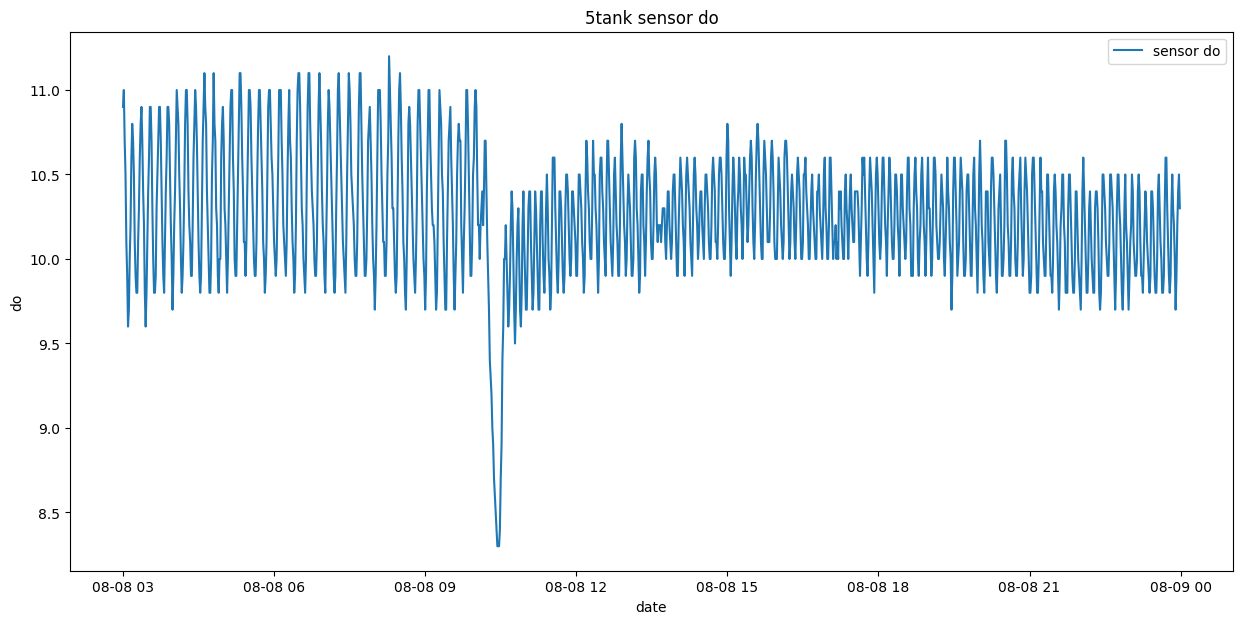

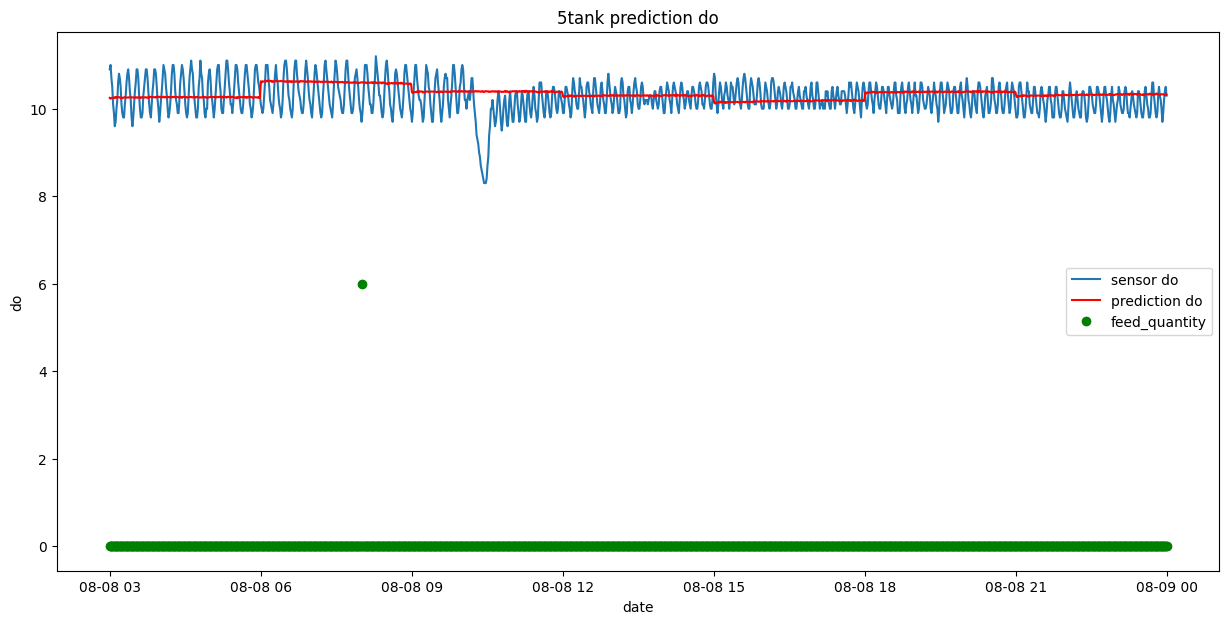

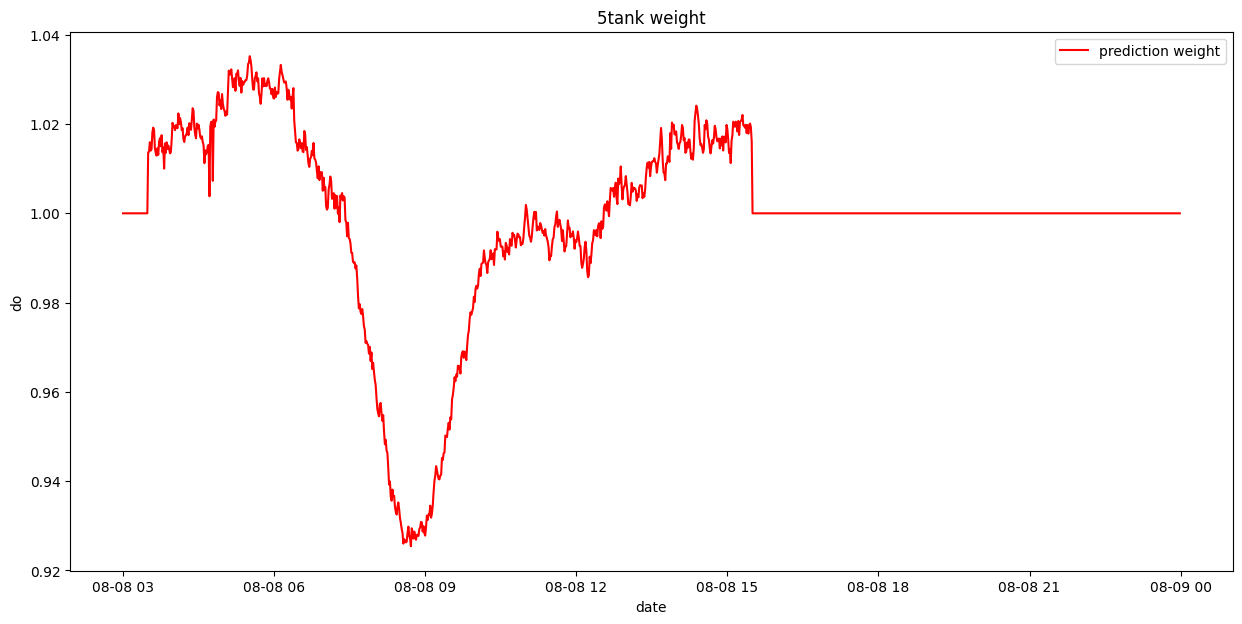

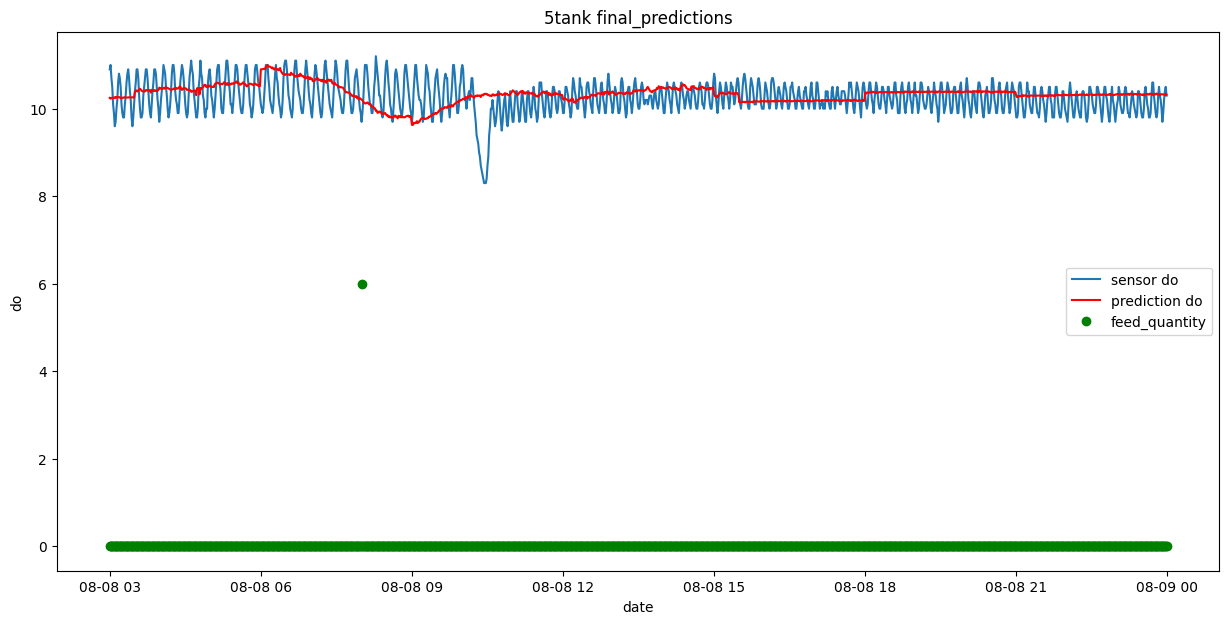

Euclidean Distance
 14.142853374156227  →  15.029184383594751
Cosine Similarity
 0.9992852846707964  →  0.9991799655409797
Correlation Coefficient
 0.9618667051076624  →  0.9543365866458324
Mean Squared Error
 0.15874627108165248  →  0.17926697082229237
Mean Absolute Error
 0.3073483520083957  →  0.3217291815581823
Correlation Coefficient
 0.038133294892337605  →  0.045663413354167626


In [19]:
y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-08-08 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-08 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-08 03:00':'2021-08-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-08 00:00':'2021-08-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-08 03:00':'2021-08-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 97ms/step


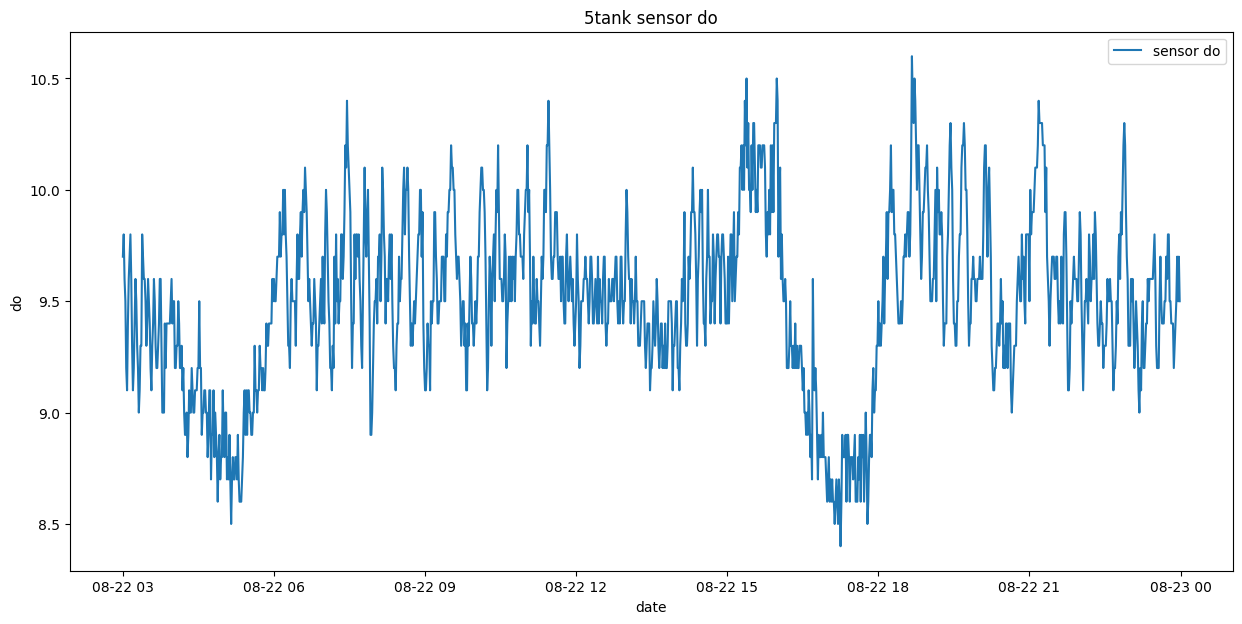

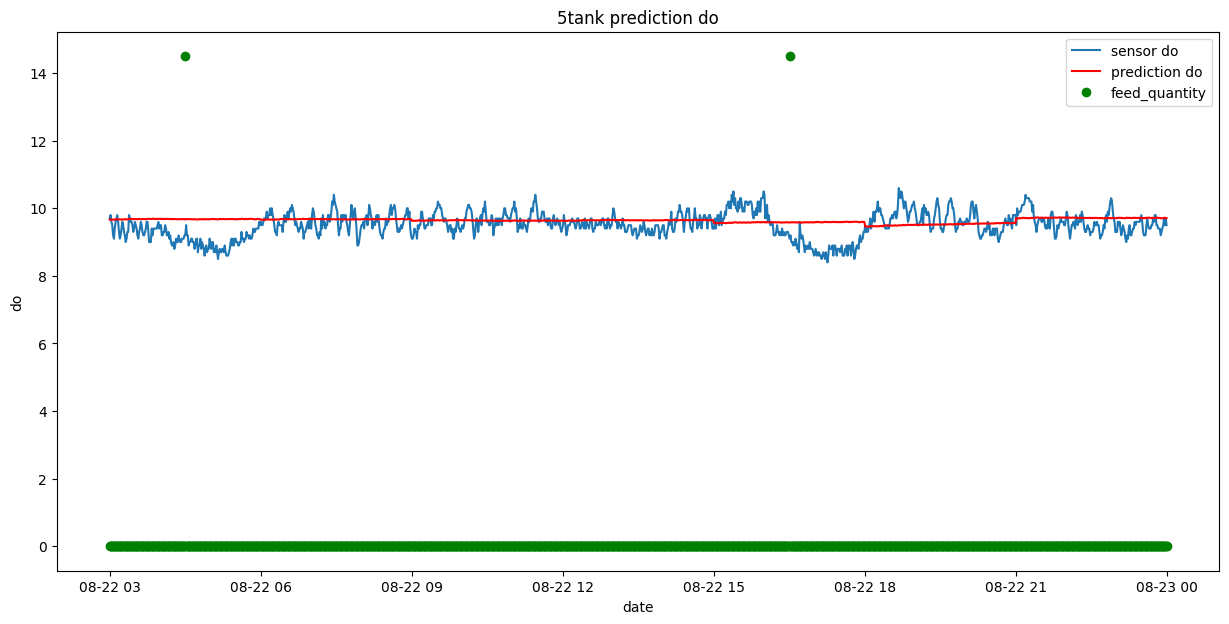

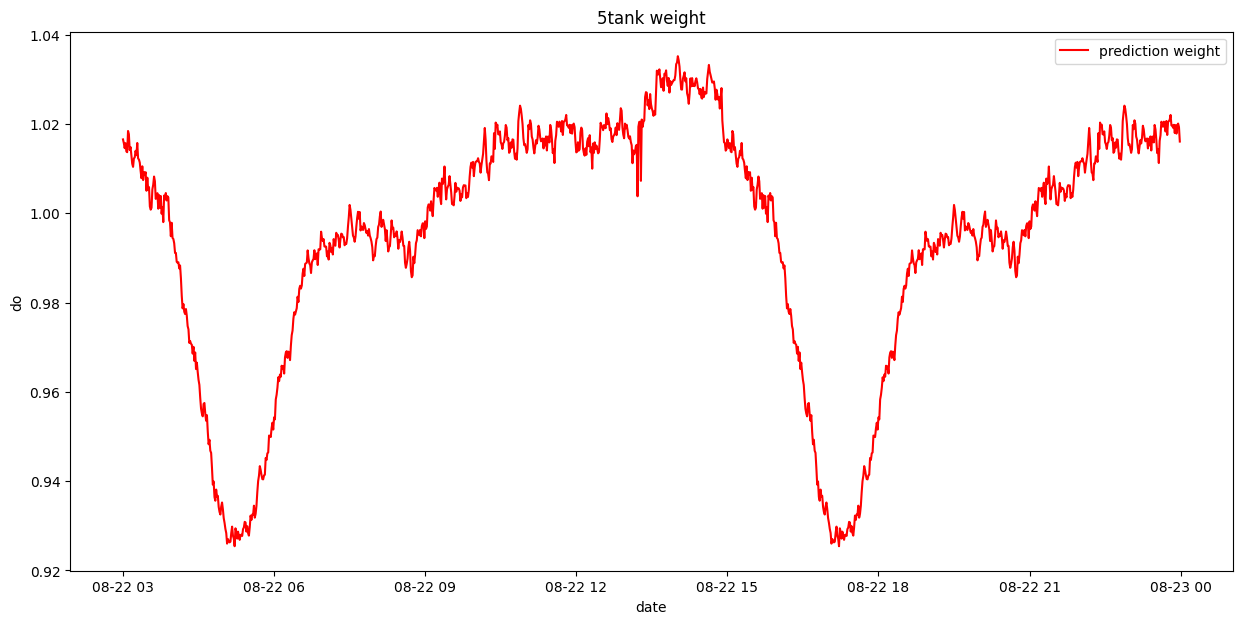

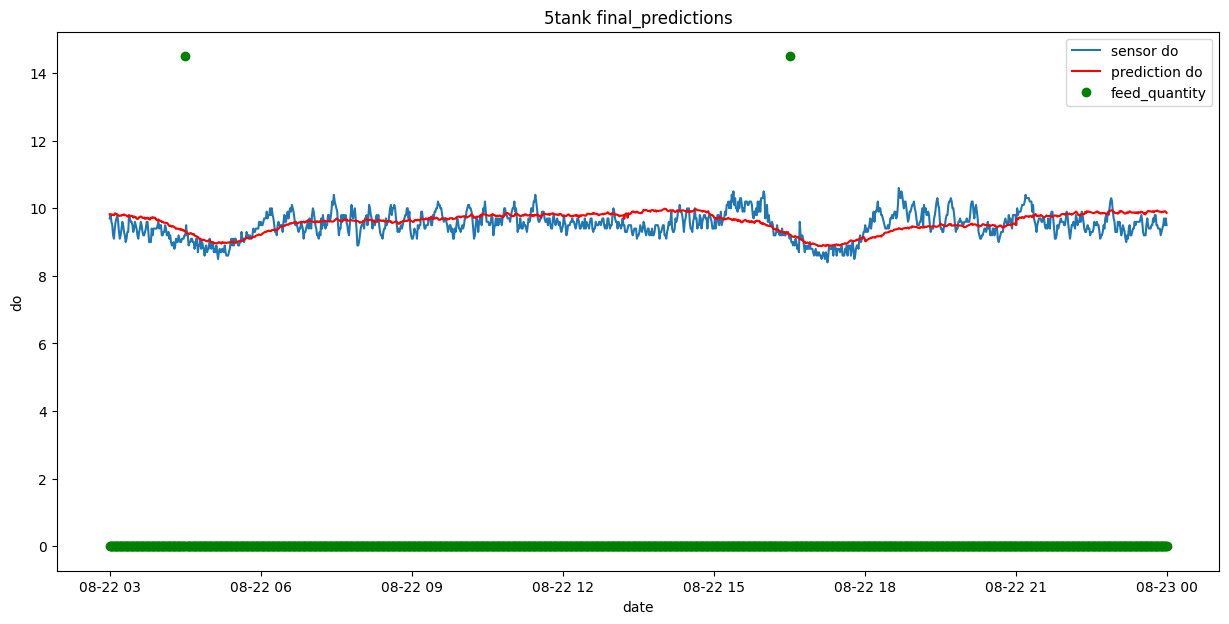

Euclidean Distance
 14.751988756573743  →  12.645279895512163
Cosine Similarity
 0.9991463729433938  →  0.9993393389441361
Correlation Coefficient
 1.133891967003014  →  0.5119208725932252
Mean Squared Error
 0.17271521609053822  →  0.12690722510781274
Mean Absolute Error
 0.32802111020163877  →  0.29303782590924143
Correlation Coefficient
 -0.13389196700301412  →  0.4880791274067746
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9


C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\3104361273.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-08-22 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\3104361273.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-22 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 97ms/step


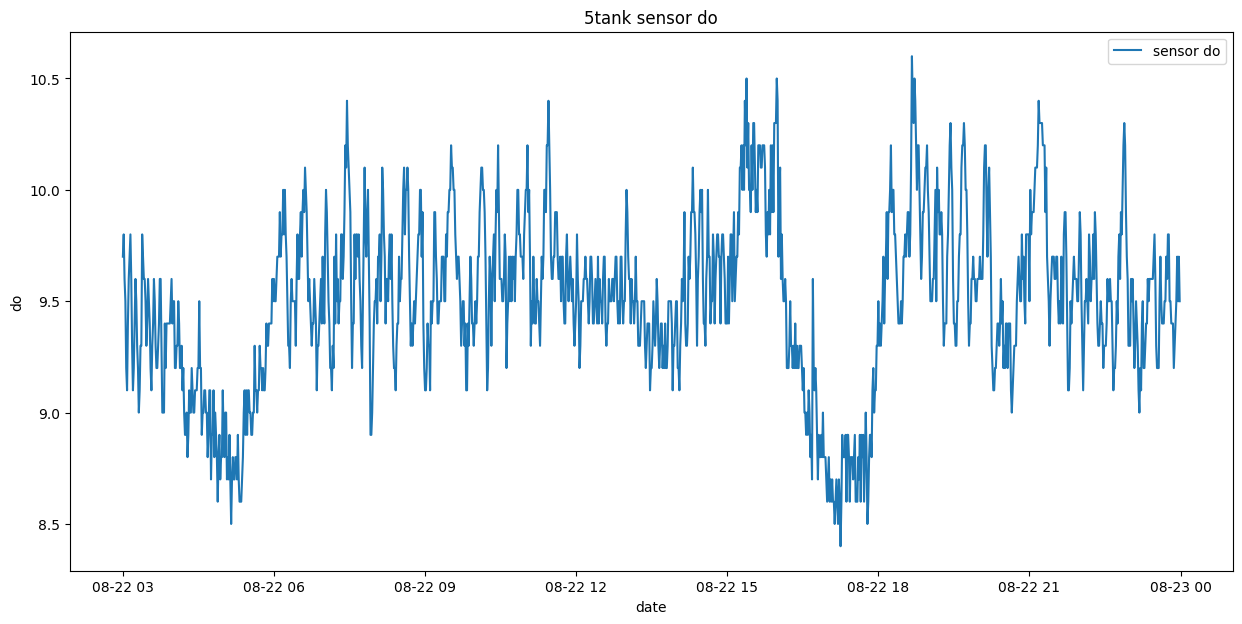

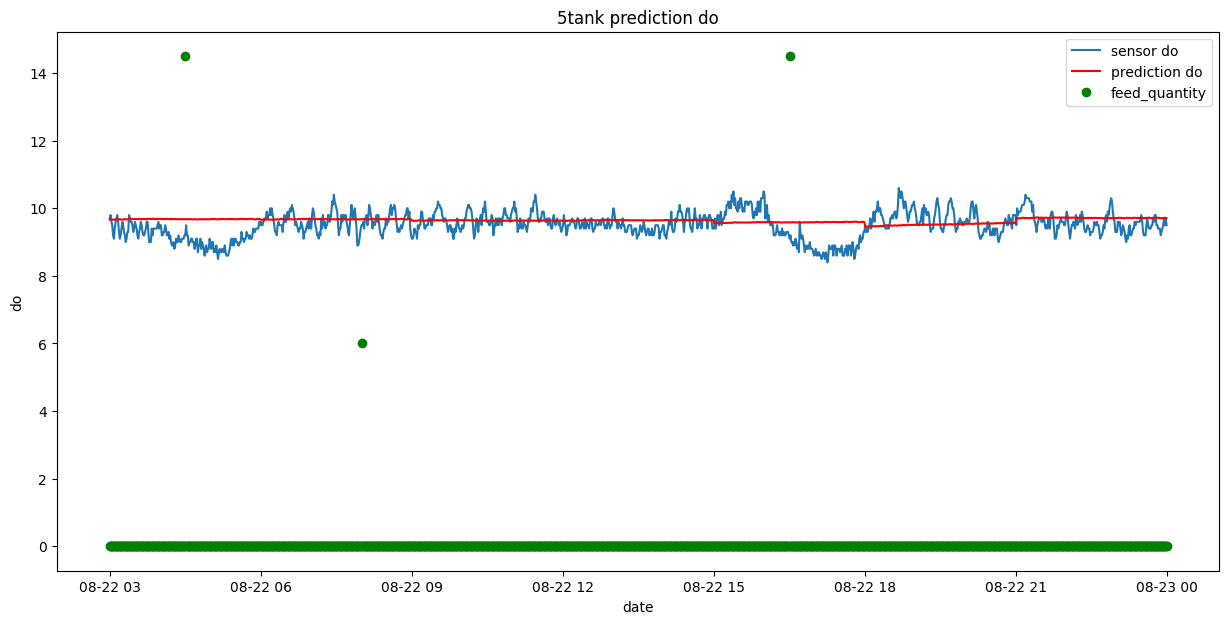

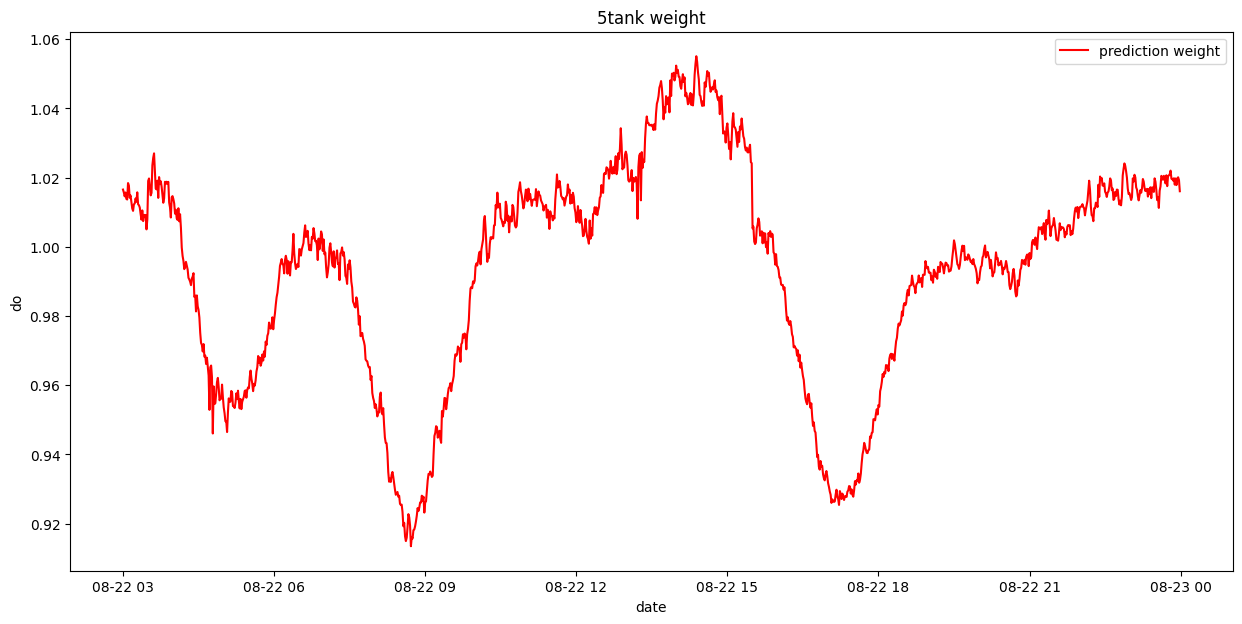

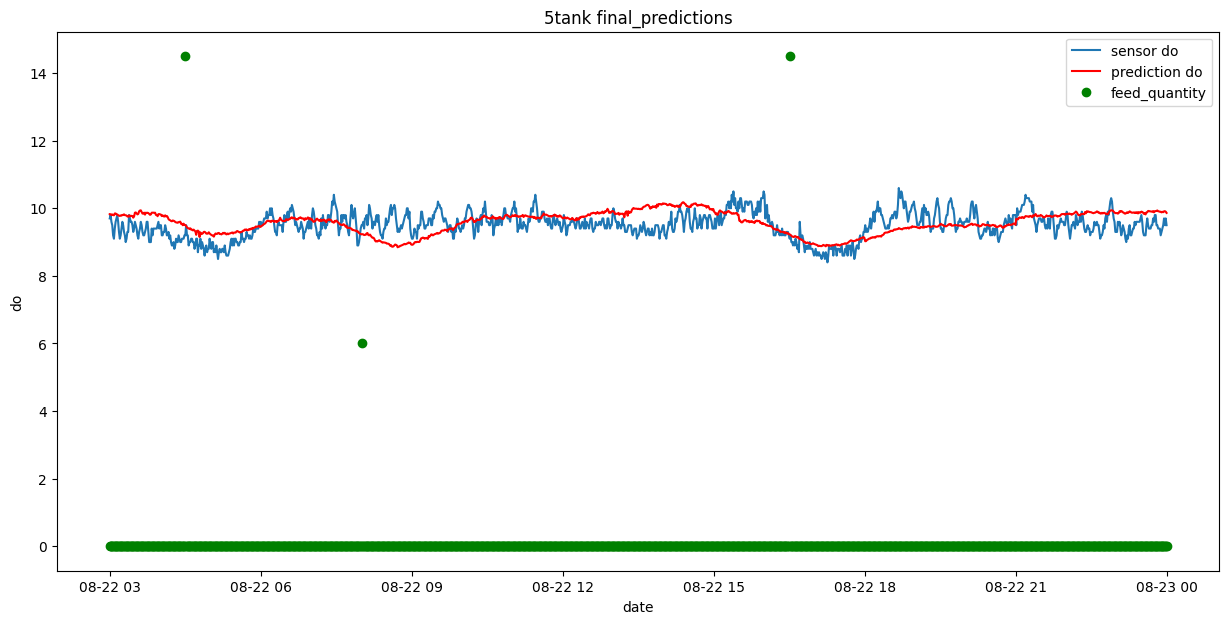

Euclidean Distance
 14.751989501902463  →  14.721554406015025
Cosine Similarity
 0.9991463728616493  →  0.9990827292381899
Correlation Coefficient
 1.1338922676483134  →  0.6736153691840614
Mean Squared Error
 0.17271523354304802  →  0.17200330486449242
Mean Absolute Error
 0.32802112533932637  →  0.3430500982001341
Correlation Coefficient
 -0.13389226764831338  →  0.32638463081593866


In [20]:
y_date = japonica_validation_features_y.loc['2021-08-22 03:00':'2021-08-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-22 00:00':'2021-08-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-22 03:00':'2021-08-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-08-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-22 03:00':'2021-08-22 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-22 00:00':'2021-08-22 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-22 03:00':'2021-08-22 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 107ms/step


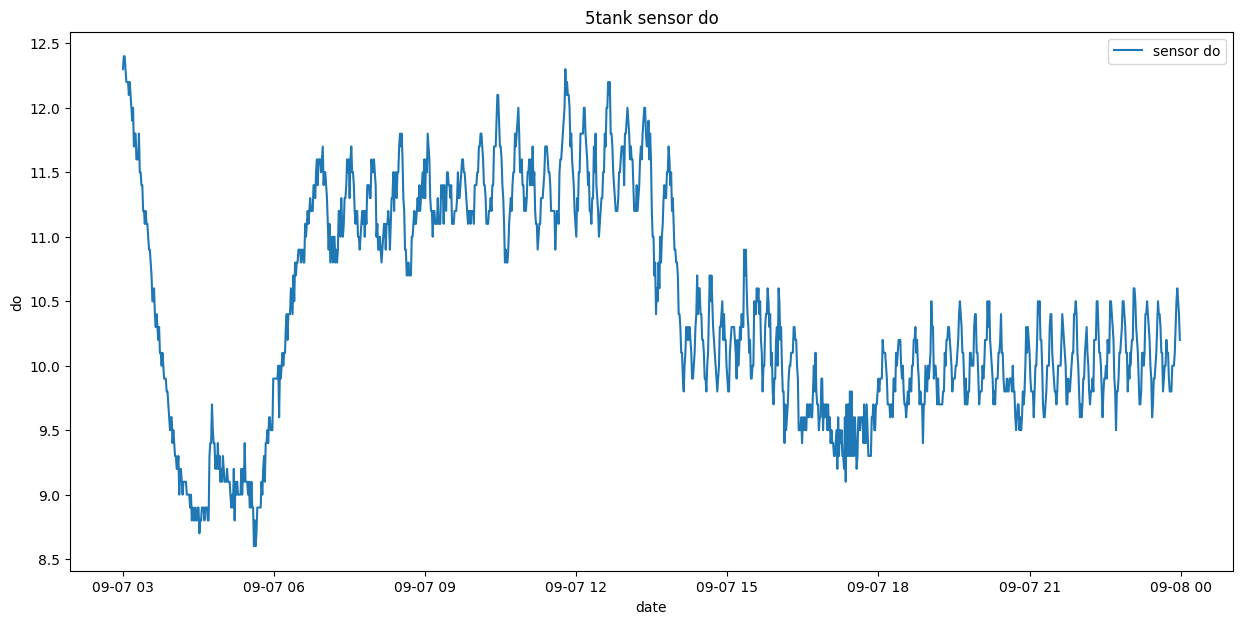

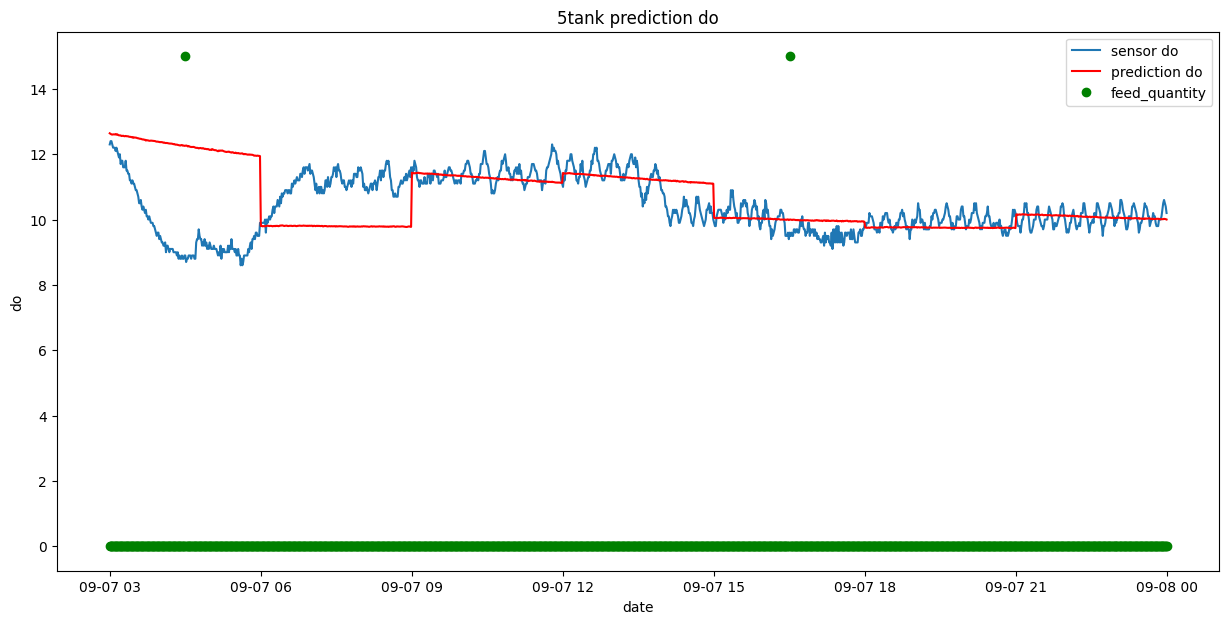

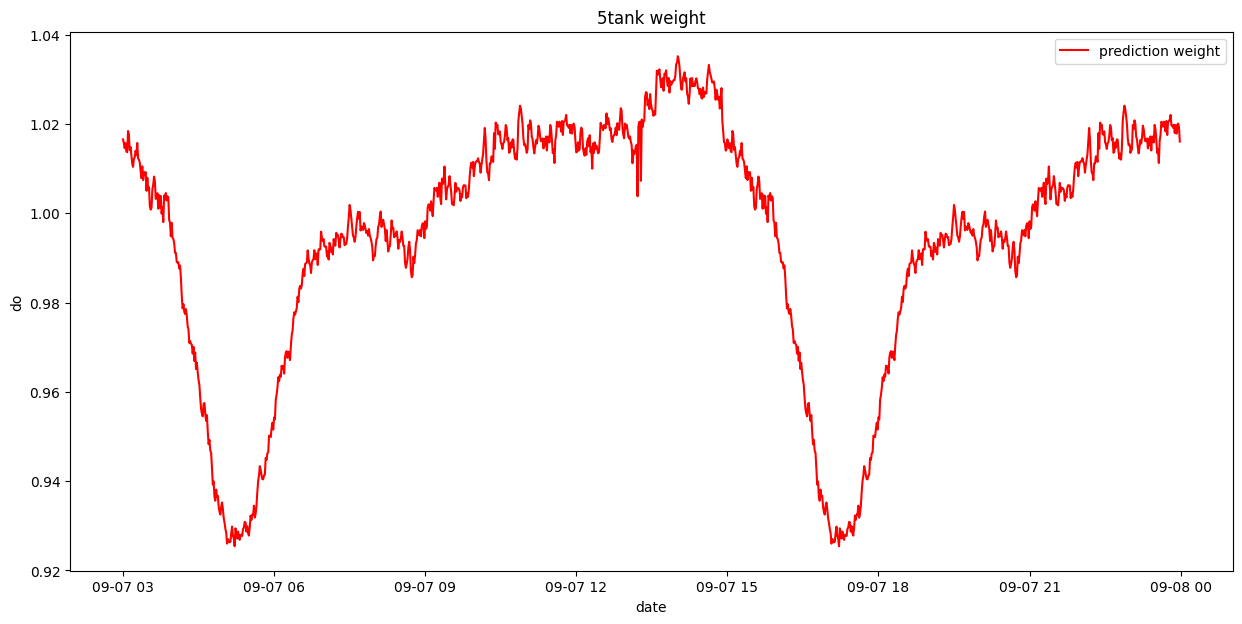

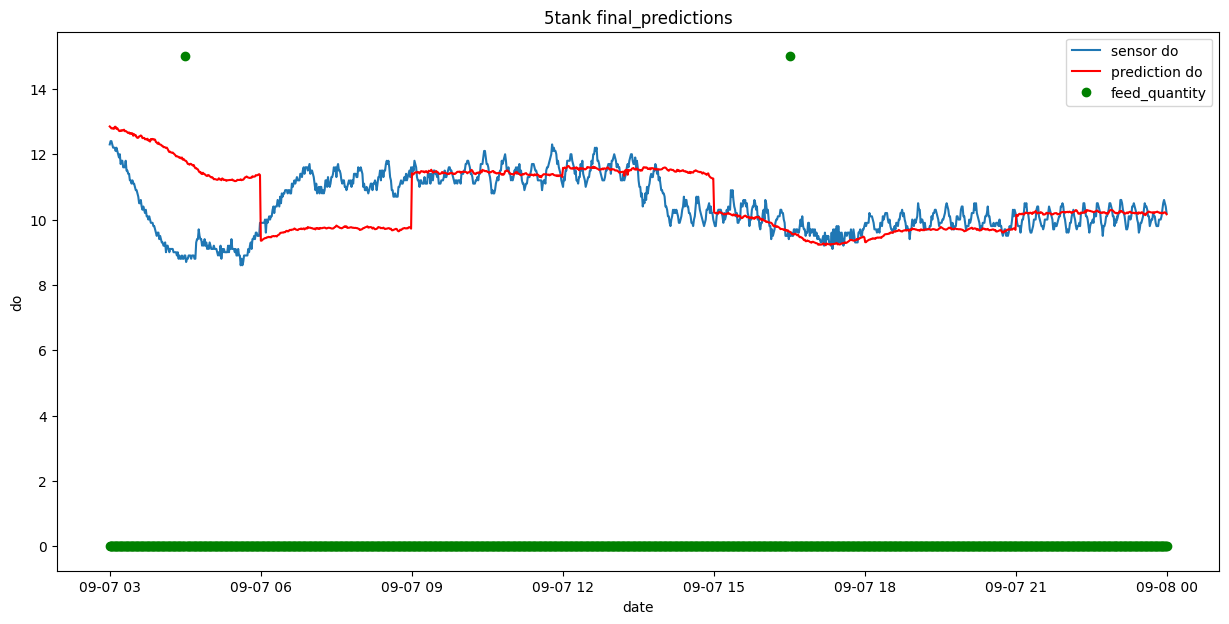

Euclidean Distance
 42.27846408853969  →  38.31374848967181
Cosine Similarity
 0.9938332833245769  →  0.9948626093114836
Correlation Coefficient
 0.8969253531998653  →  0.6995748280149433
Mean Squared Error
 1.4186258140364603  →  1.165034383595103
Mean Absolute Error
 0.7717439615158808  →  0.7387975153262315
Correlation Coefficient
 0.1030746468001346  →  0.30042517198505686
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9


C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\525826336.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-09-07 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_14344\525826336.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-09-07 08:00', 'feed_quantity'] = 6


1/1 [==============================] - 0s 94ms/step


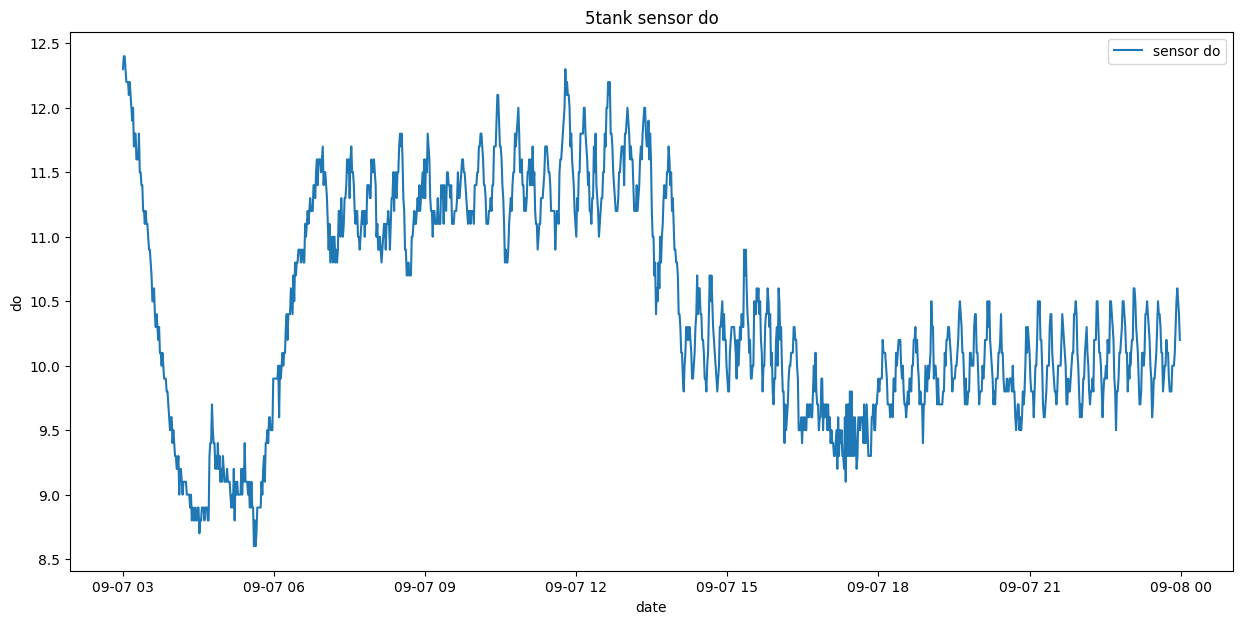

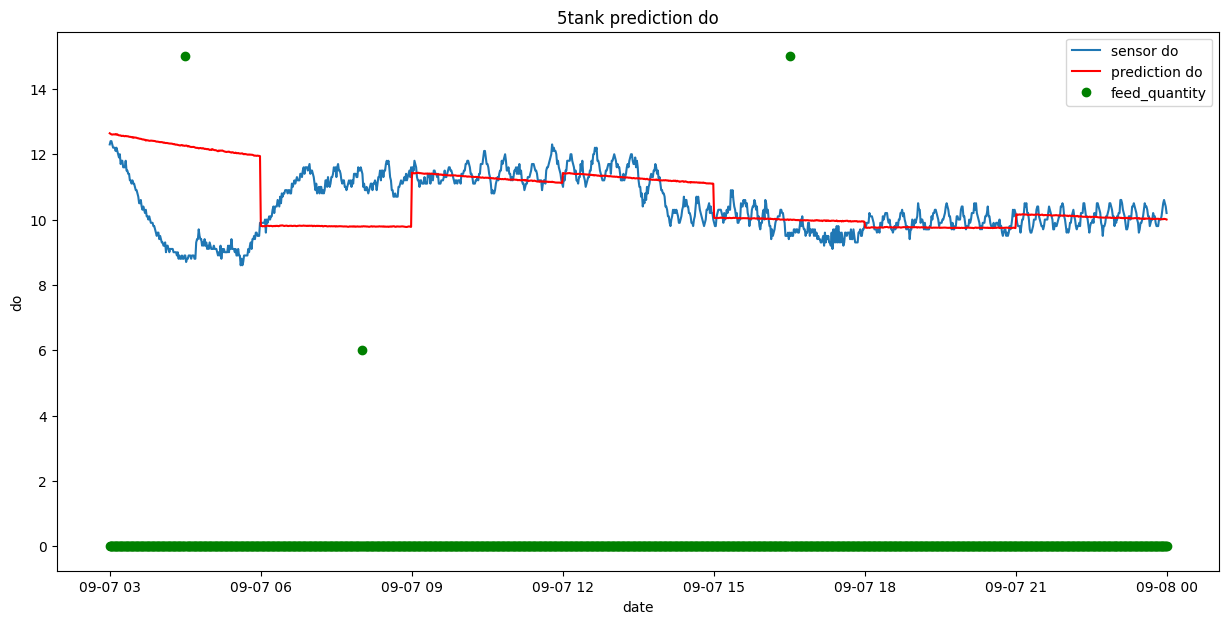

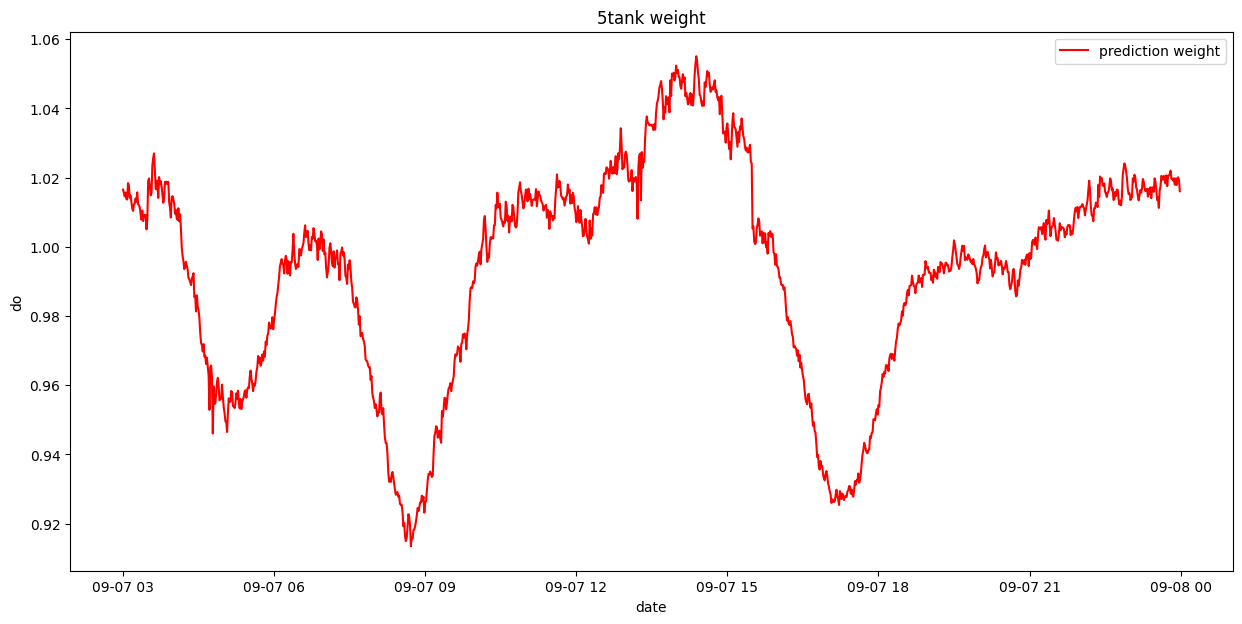

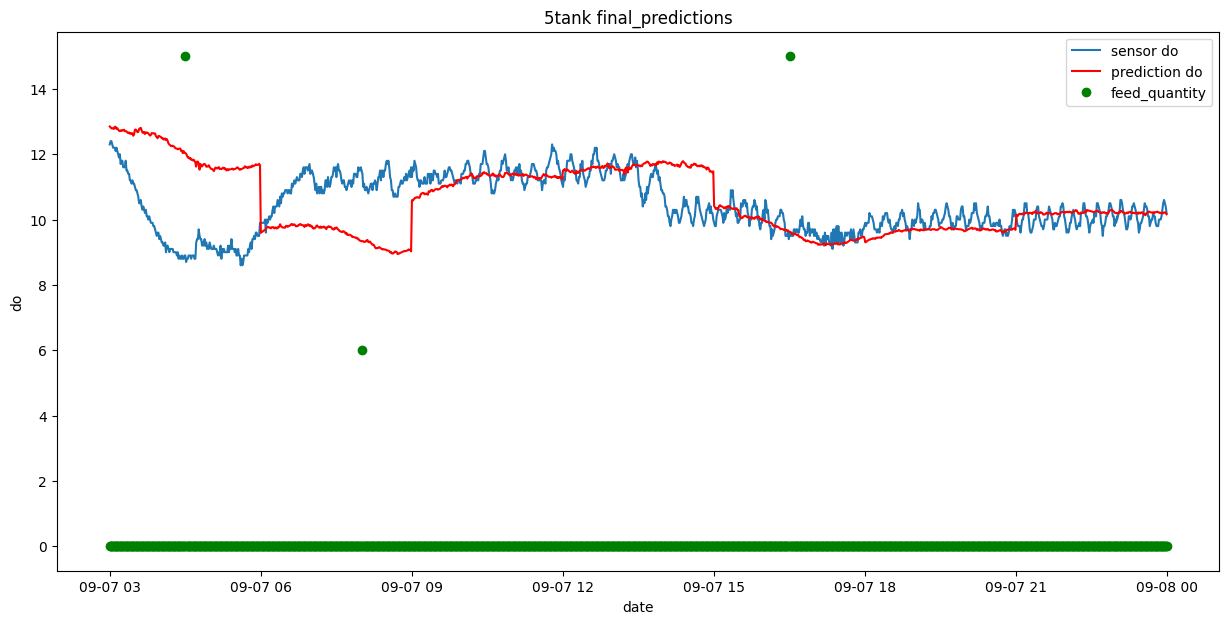

Euclidean Distance
 42.27860999564097  →  42.89049595431961
Cosine Similarity
 0.9938331405058214  →  0.9935318162038951
Correlation Coefficient
 0.8969719605723031  →  0.821370533927346
Mean Squared Error
 1.4186356056853273  →  1.4599957485773865
Mean Absolute Error
 0.771752047311692  →  0.817819415452435
Correlation Coefficient
 0.10302803942769707  →  0.17862946607265393


In [21]:
y_date = japonica_validation_features_y.loc['2021-09-07 03:00':'2021-09-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-07 00:00':'2021-09-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-07 03:00':'2021-09-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-09-07 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-09-07 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-09-07 03:00':'2021-09-07 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-09-07 00:00':'2021-09-07 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-09-07 03:00':'2021-09-07 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 8))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)